# Predicción de procesos abiertos por departamento

## Importando las librerías necesarias 


In [1]:
import numpy as np
import pandas as pd
import functions as ft #Definición y contenido en 'backend/models/functions.py'
import os
import matplotlib.pyplot as plt

# Importe,segmentación, ordenado y limpieza del dataset

En esta sección nos interesa lograr los siguientes items: 

* Dividir el dataset por departamentos
* Dentro de los departamentos, contar la cantidad de procesos solicitados por día
* Crear una línea de tiempo continua, lo que implica que todos los días del año deben estar dentro de cada subdataset.

In [2]:
df = pd.read_csv("../data/processed/unified_data.csv")
print(df.head())
print(df.shape)
print(df.dtypes)

   IdSolicitud                                         NomEntidad  \
0       481137  UNIVERSIDAD  FACULTAD DE DERECHO  CONSULTORIOJ...   
1      3930874  UNIVERSIDAD  FACULTAD DE DERECHO  CONSULTORIOJ...   
2       414466  UNIVERSIDAD  FACULTAD DE DERECHO  CONSULTORIOJ...   
3       441614  UNIVERSIDAD  FACULTAD DE DERECHO  CONSULTORIOJ...   
4        39309  UNIVERSIDAD  FACULTAD DE DERECHO  CONSULTORIOJ...   

           NomCasaJusticia FechaSolicitud  days  months  years  day_of_week  \
0  CASA DE JUSTICIA CAJICA     2019-10-21    21      10   2019            1   
1  CASA DE JUSTICIA CAJICA     2019-05-08     8       5   2019            3   
2  CASA DE JUSTICIA CAJICA     2019-09-16    16       9   2019            1   
3  CASA DE JUSTICIA CAJICA     2019-09-30    30       9   2019            1   
4  CASA DE JUSTICIA CAJICA     2019-05-08     8       5   2019            3   

   COD_DPTO  COD_MPIO        VULNERABILITY  IPM-mean  IPM-median  \
0        25       126  Vulnerabilidad baja

Como puede observarse, la fecha sigue almacenada en formato object, por lo que la modificaremos a datetime

In [3]:
df["FechaSolicitud"] = pd.to_datetime(df["FechaSolicitud"])

Además, de aquí en adelante solo nos interesará la fecha de la solicitud y su departamento, por lo que eliminaremos el resto de columnas.

In [4]:
df.drop(['COD_MPIO', 'Municipio', 'days', 'months', 'years', 'day_of_week', 'NomCasaJusticia', 'NomEntidad', 'IdSolicitud', 'VULNERABILITY', 'IPM-mean','IPM-median','PREGANCY', 'REACTIVATION'], axis = 1, inplace = True)

df.head()

FechaSolicitud  COD_DPTO  Departamento
0     2019-10-21        25  CUNDINAMARCA
1     2019-05-08        25  CUNDINAMARCA
2     2019-09-16        25  CUNDINAMARCA
3     2019-09-30        25  CUNDINAMARCA
4     2019-05-08        25  CUNDINAMARCA

## División por departamentos 

Con el dataframe inicial listo, se procede a dividirlo en subdataframes, uno para cada departamento

In [5]:
# Comprobar que no haya pérdida de información

dfs = ft.divide_dataframe(df, "Departamento")

ft.compare_rows(df, dfs)


(3607572, 3607572)


True

In [6]:
dfs.keys()

dict_keys(['ANTIOQUIA', 'ARAUCA', 'ATLANTICO', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA', 'CESAR', 'CHOCO', 'CORDOBA', 'CUNDINAMARCA', 'GUAVIARE', 'HUILA', 'LA GUAJIRA', 'MAGDALENA', 'META', 'NARIÑO', 'NORTE DE SANTANDER', 'PUTUMAYO', 'QUINDIO', 'RISARALDA', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE DEL CAUCA'])

## Conteo de procesos por día y continuidad de la serie de tiempo

Divido el dataframe, unificaremos los procesos que hayan sido realizados el mismo día por medio de un conteo. Además, se llenarán los lugares vacíos en la serie de tiempo.

In [7]:
"""
Para mayor información de cómo se realiza este proceso, remitirse a functions.py en la
función create_continuous_time_series, que realiza todo el procedimiento. Allí puede encontrar el código y la documentació relevante
"""
for key in dfs.keys():
    dfs[key] = ft.create_continuos_time_series(dfs[key])
    

## Visualización de casos por día

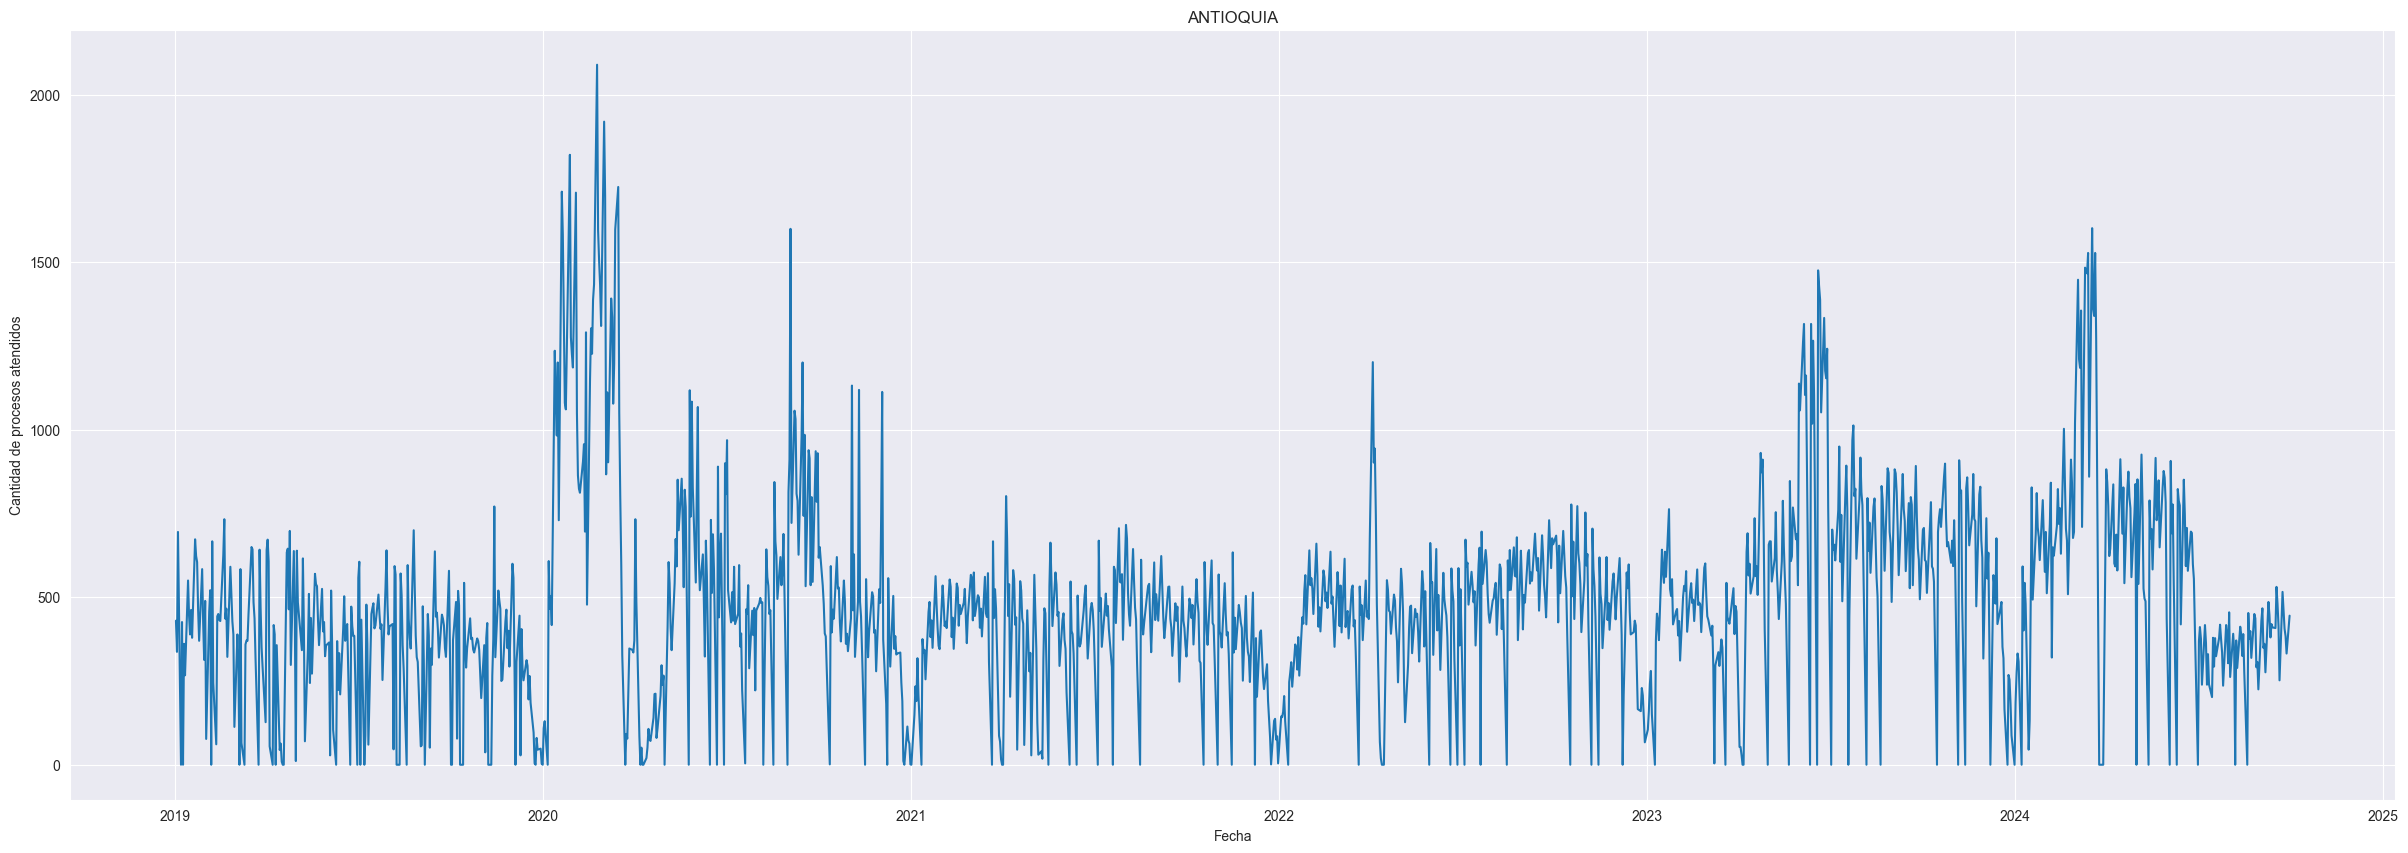

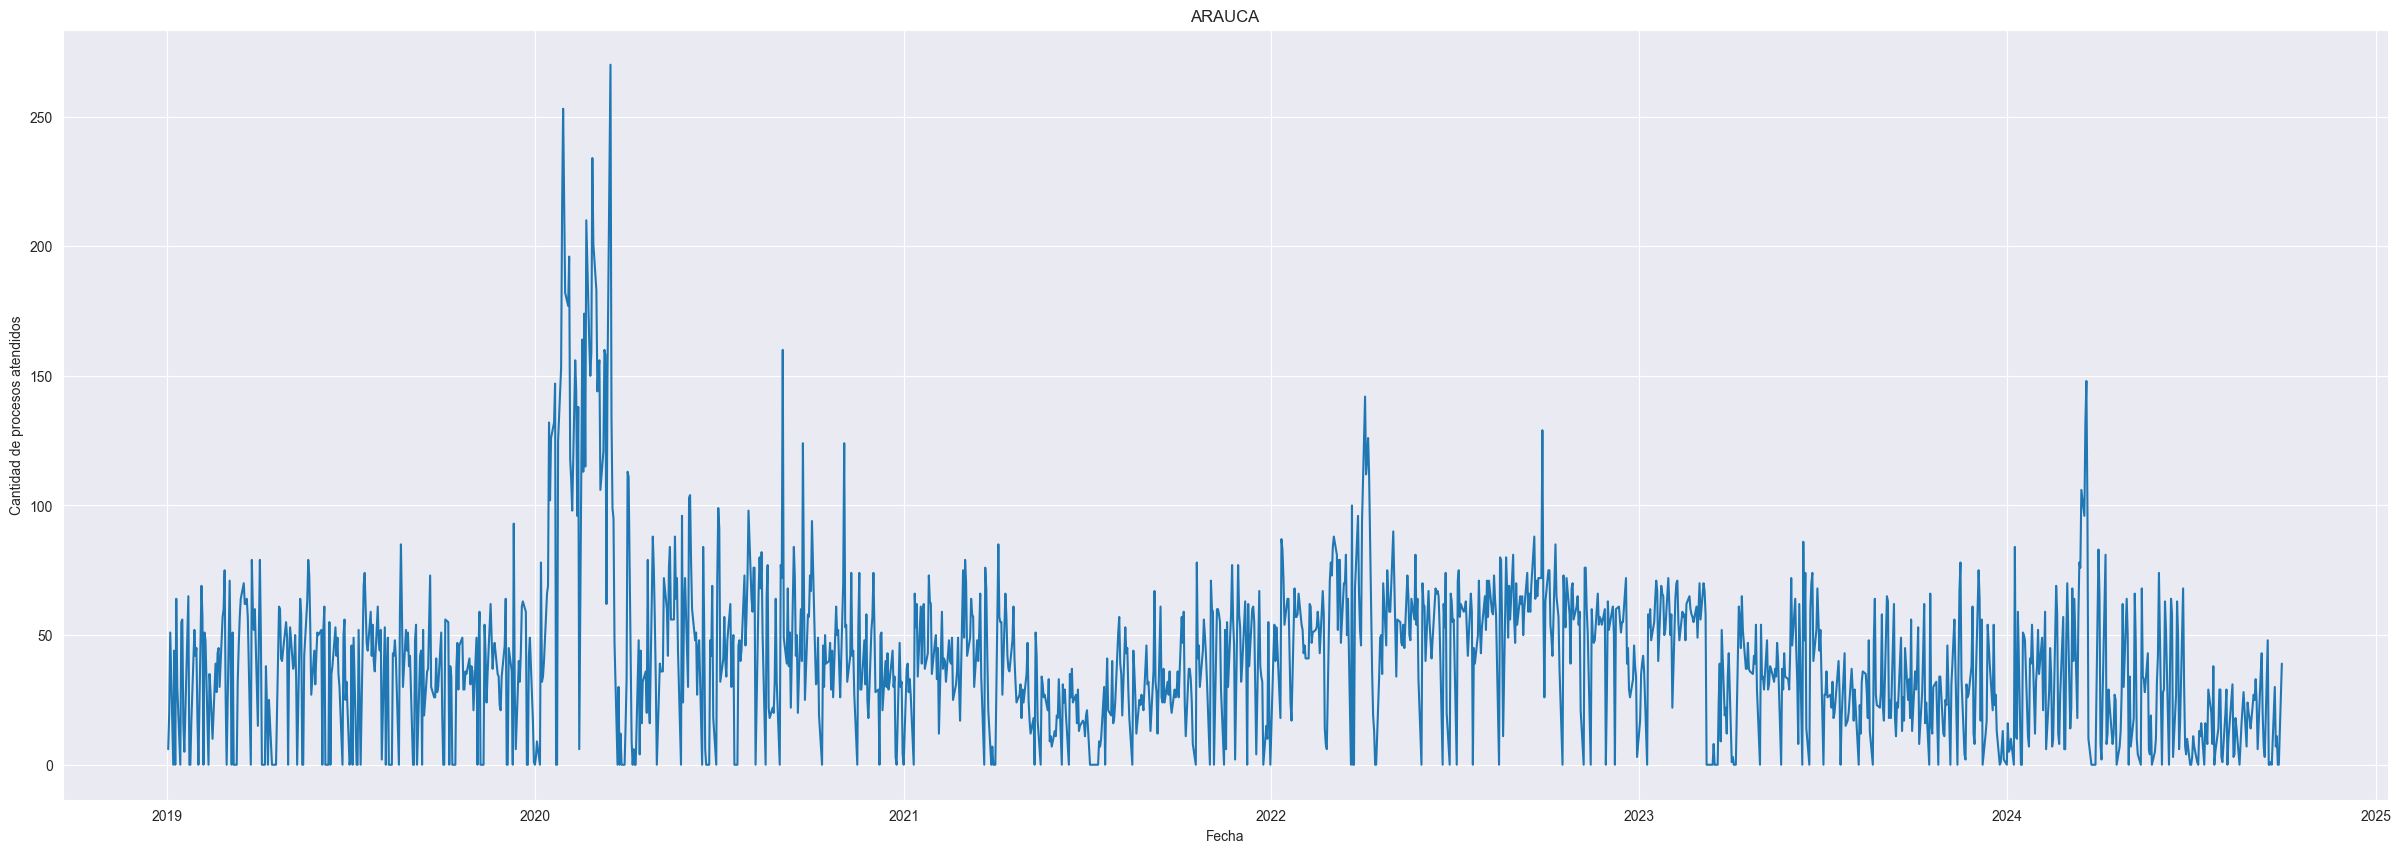

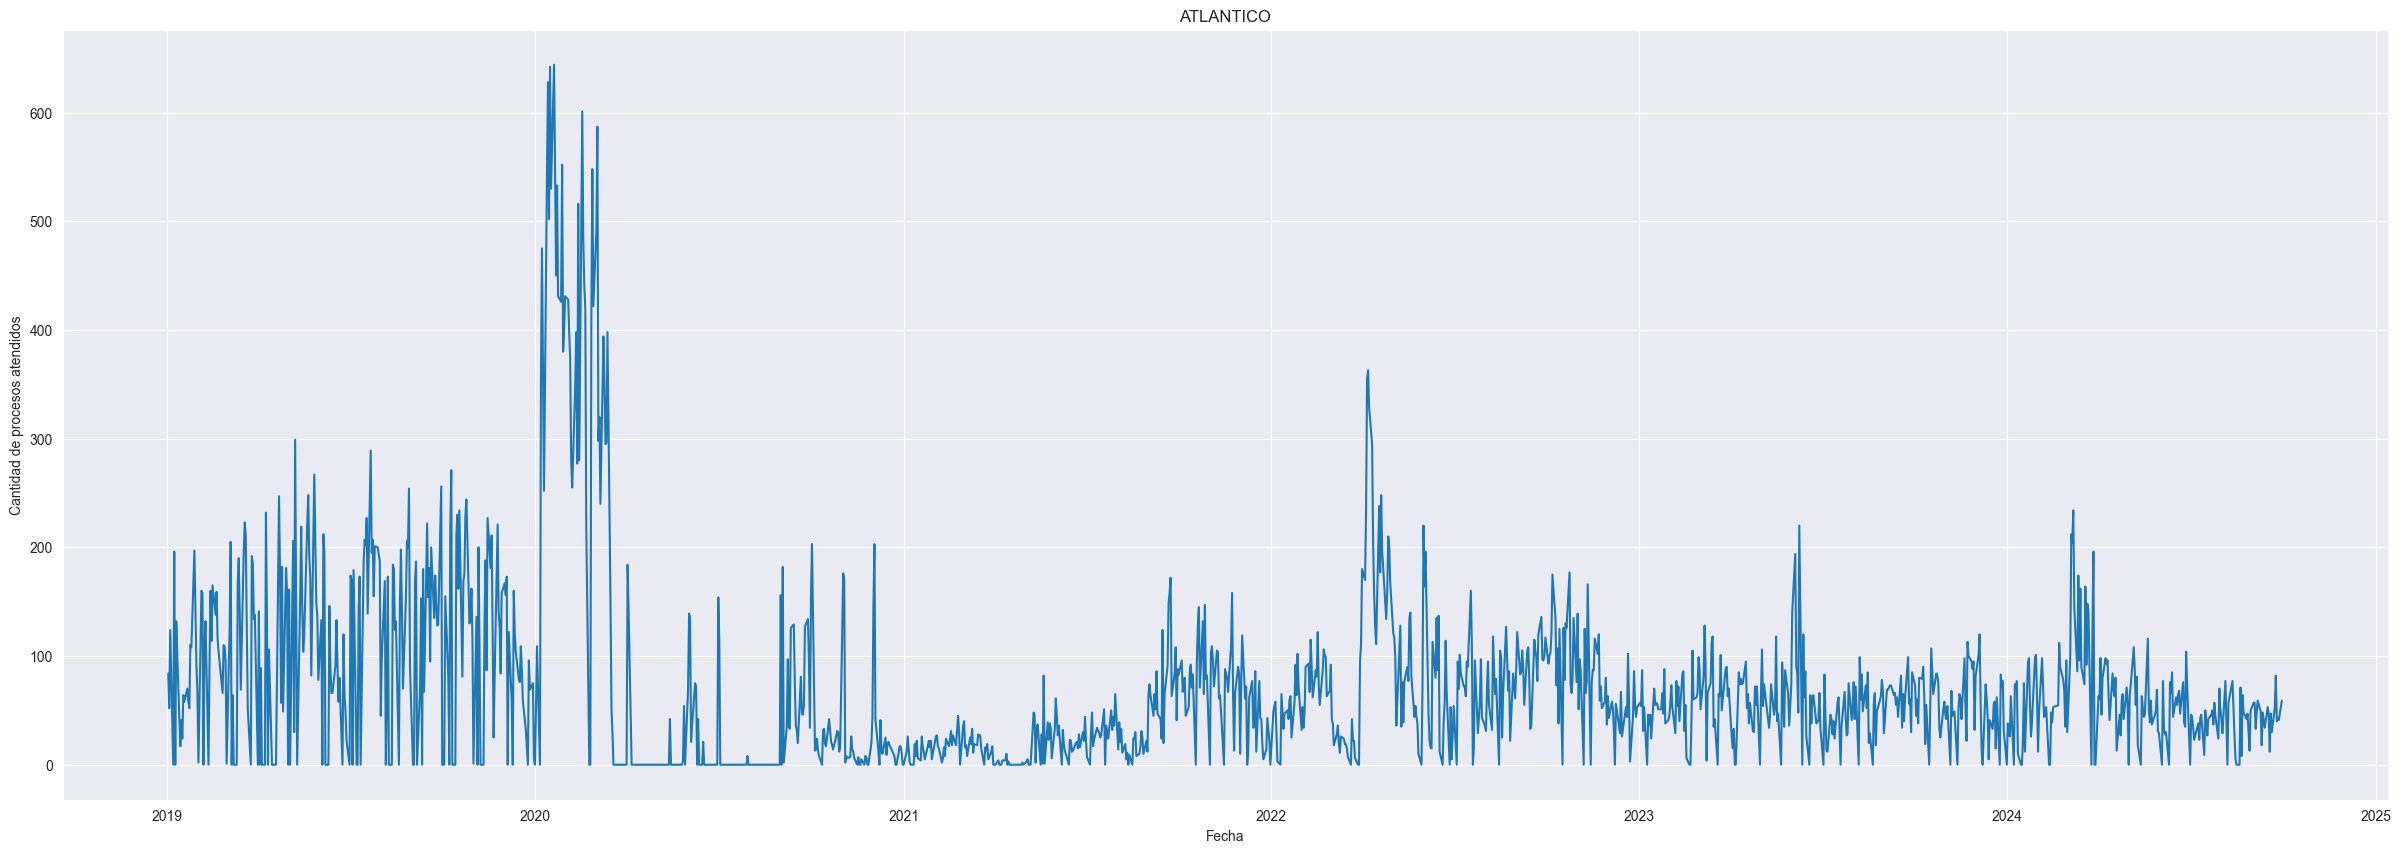

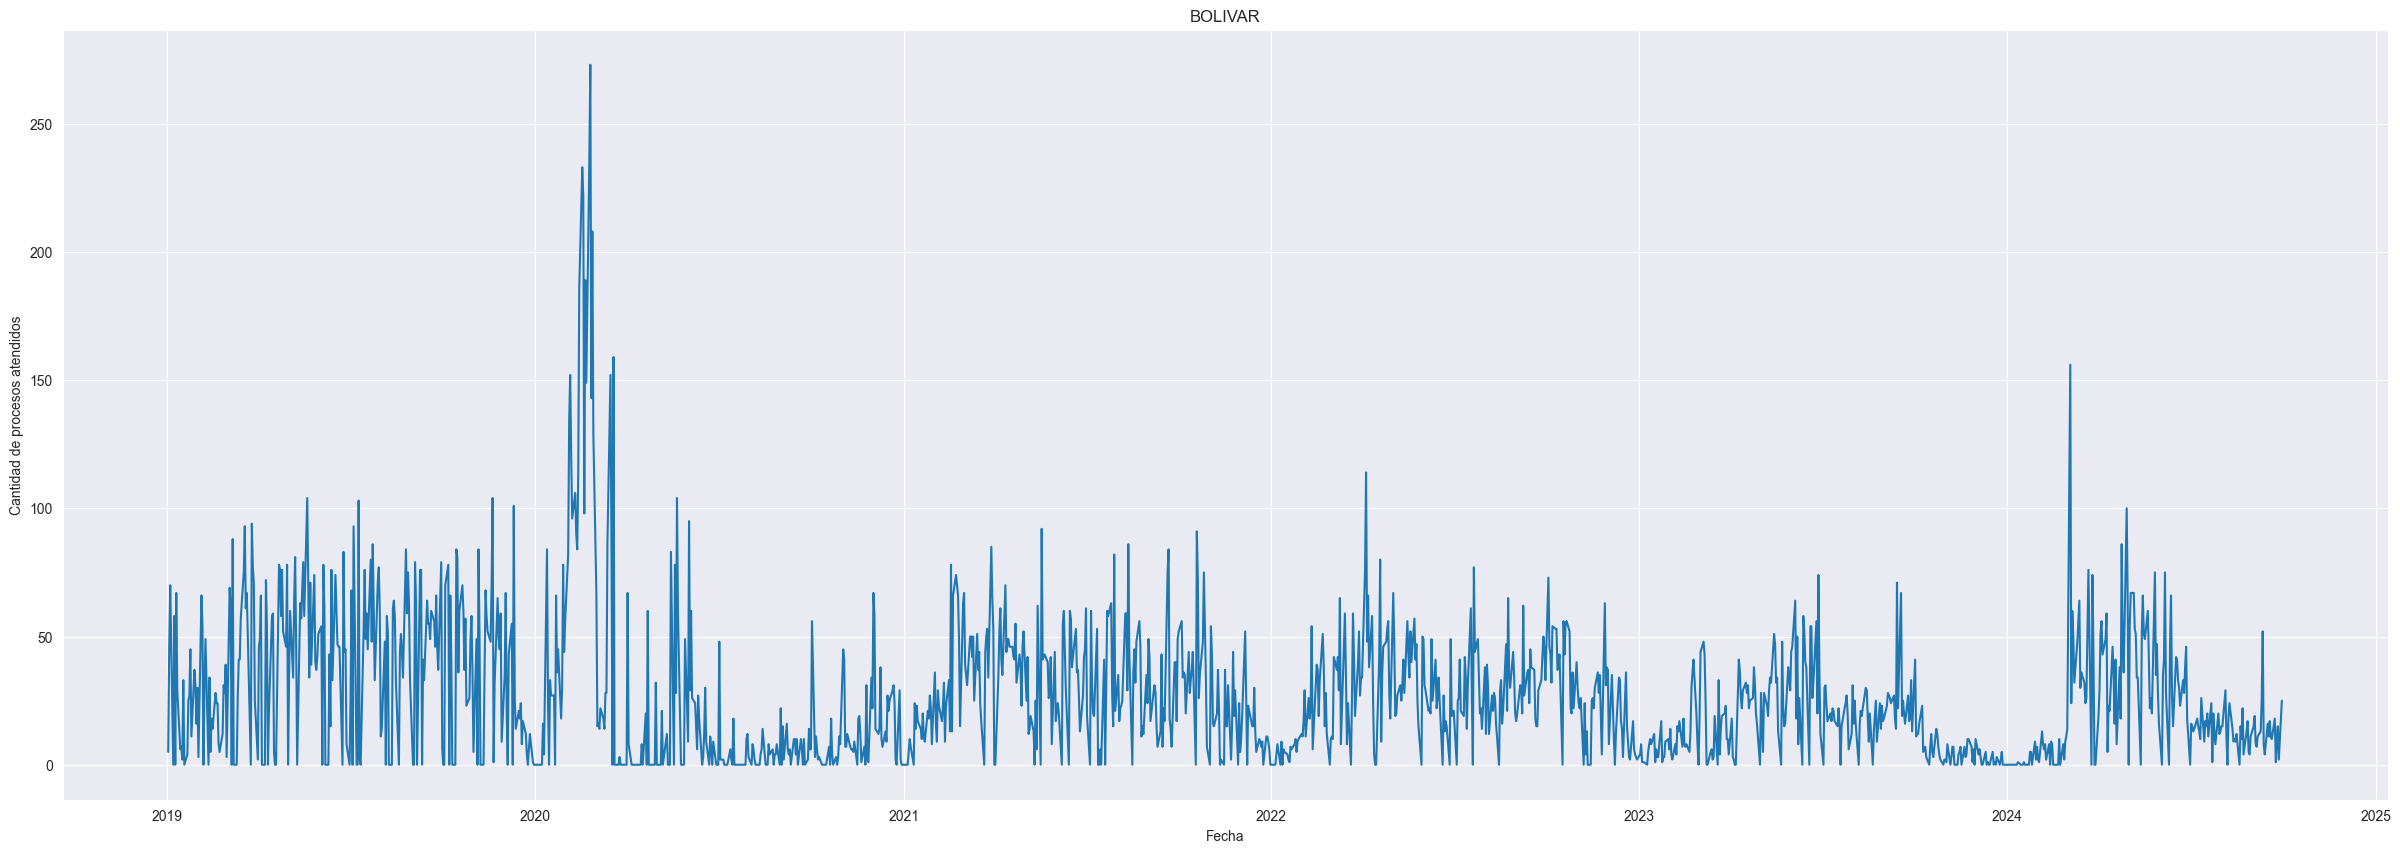

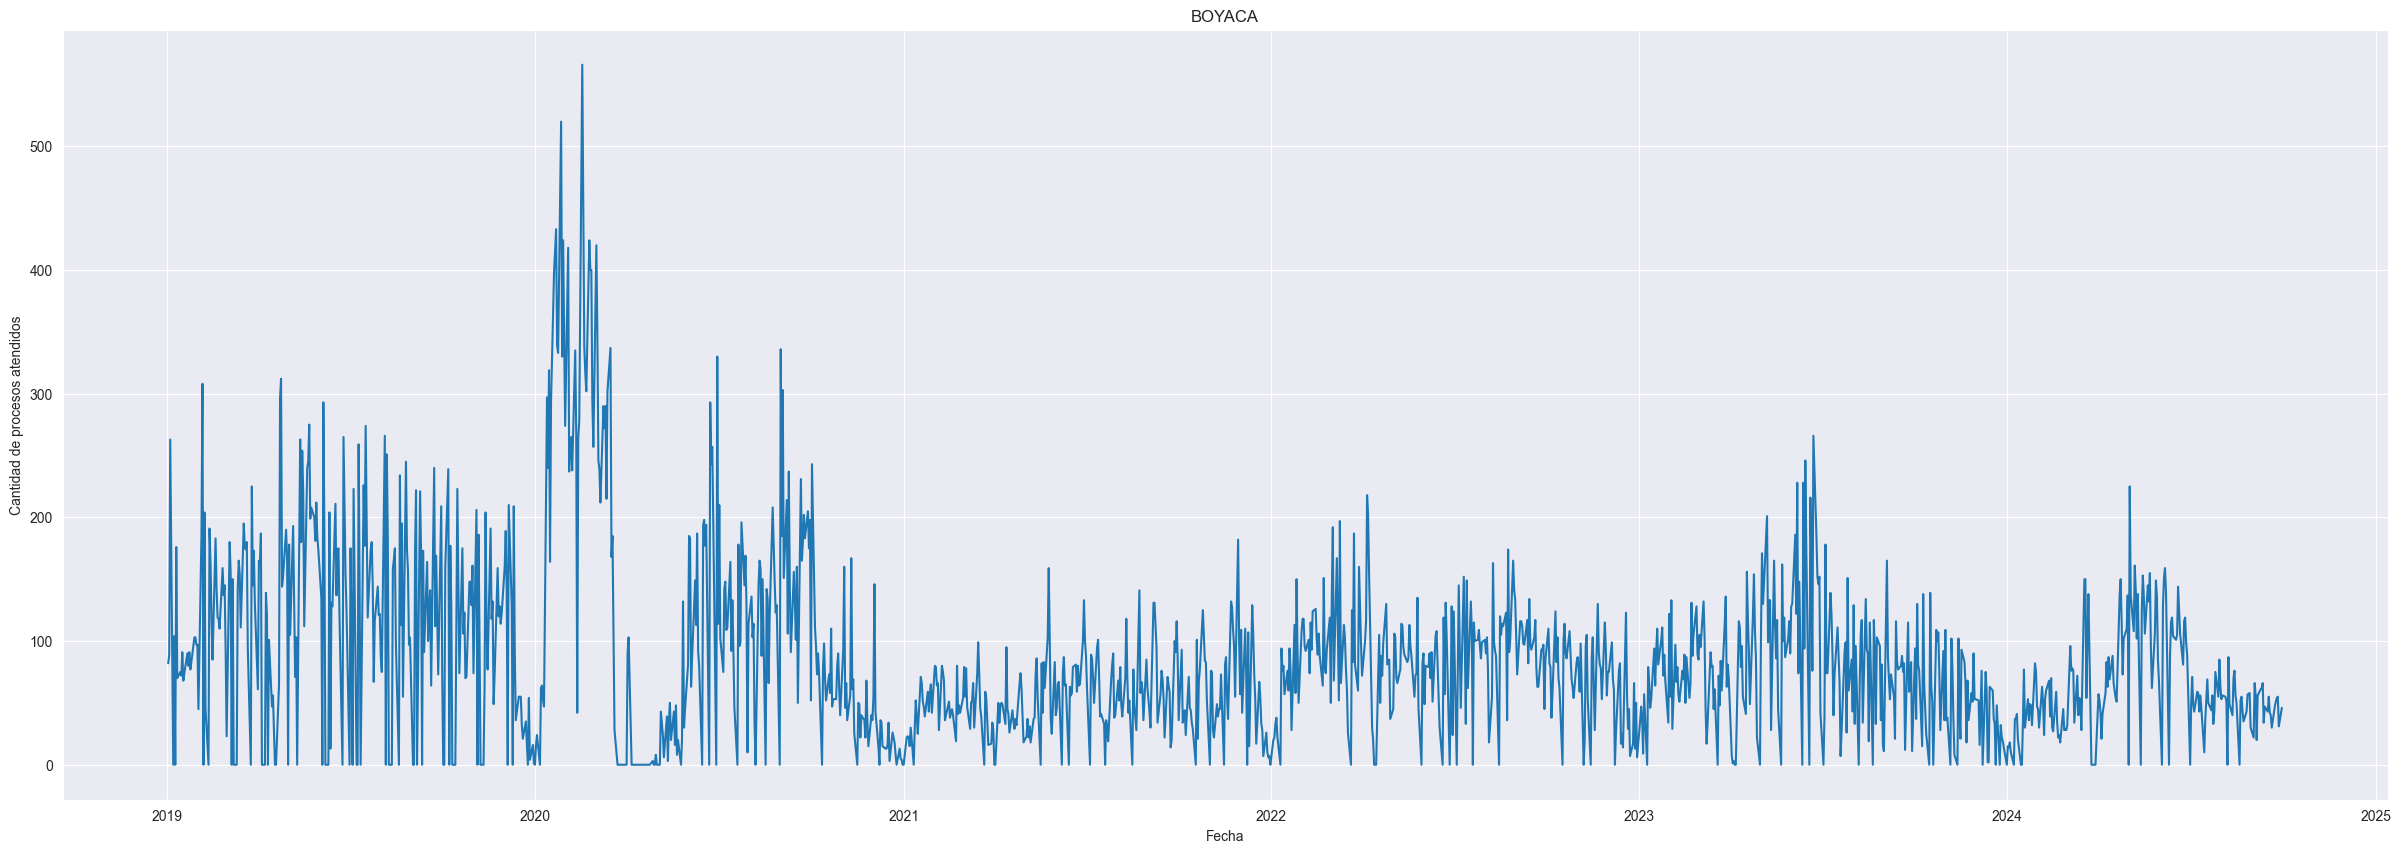

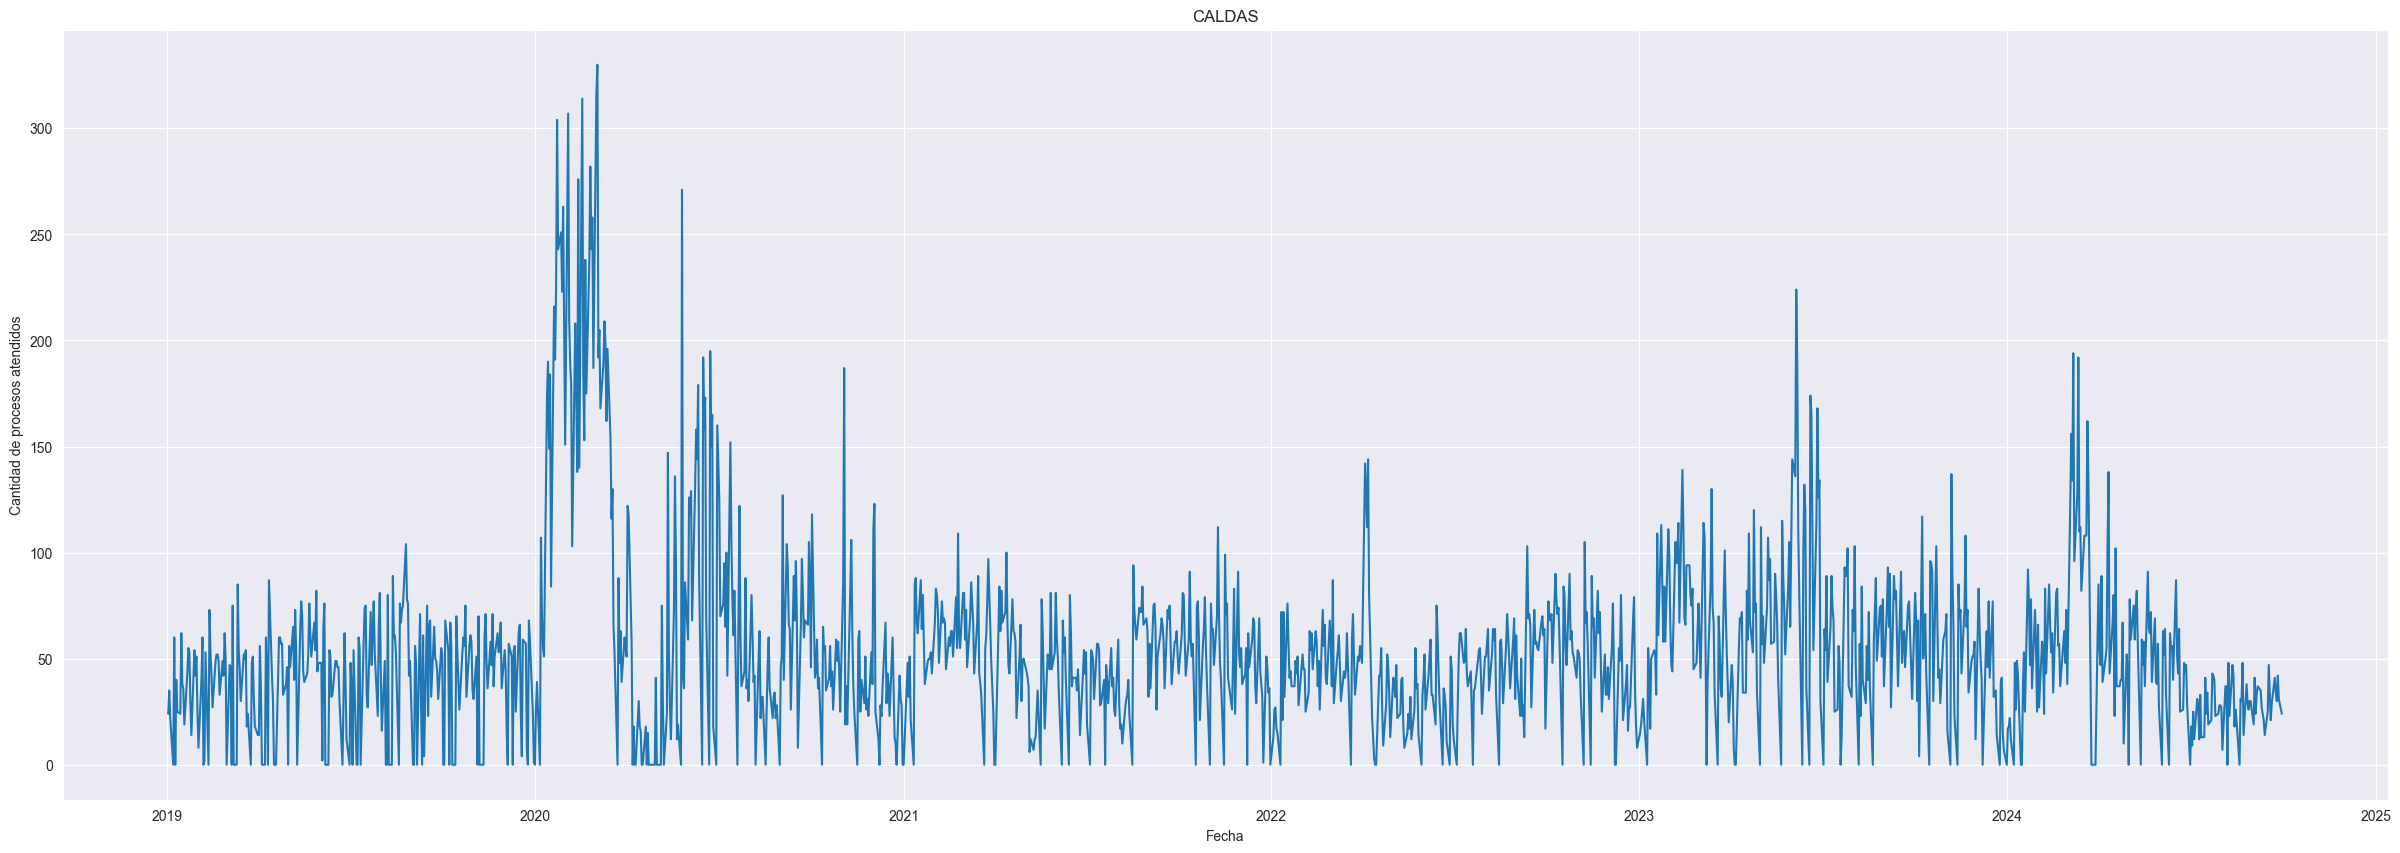

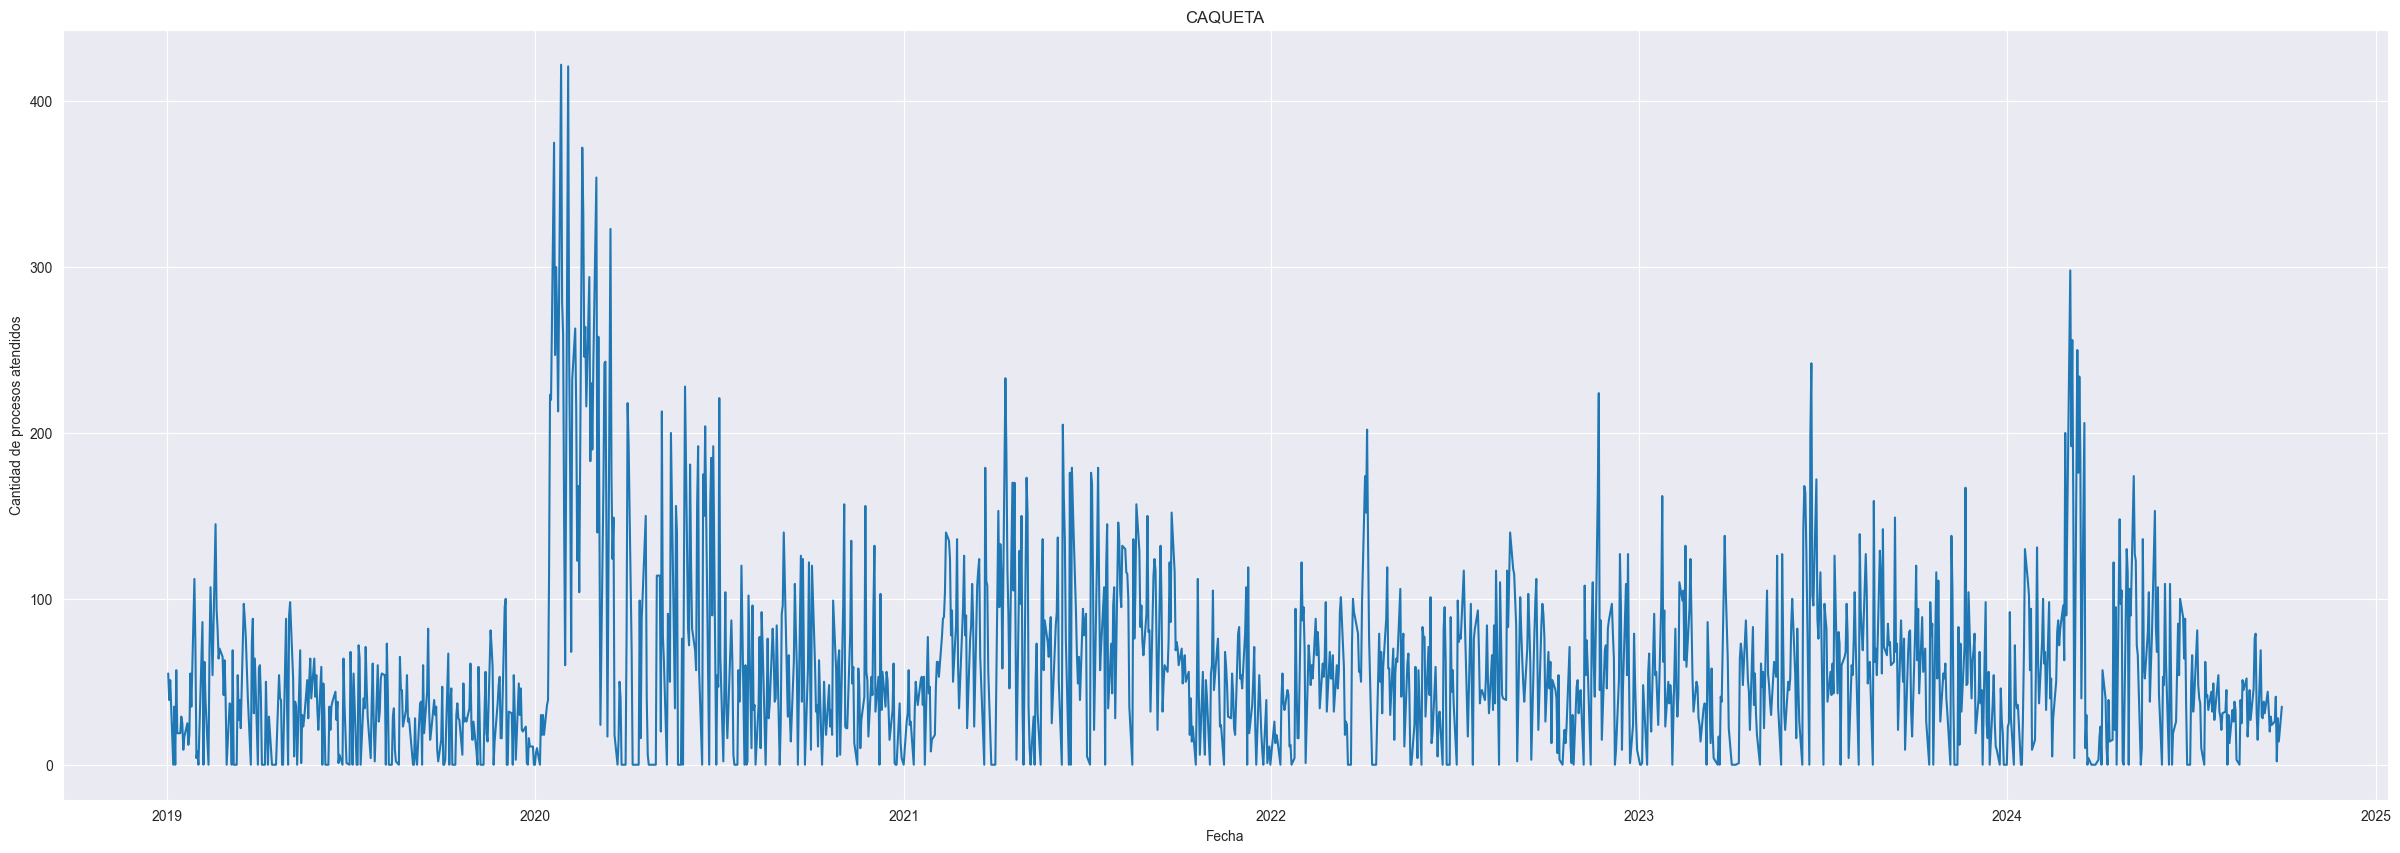

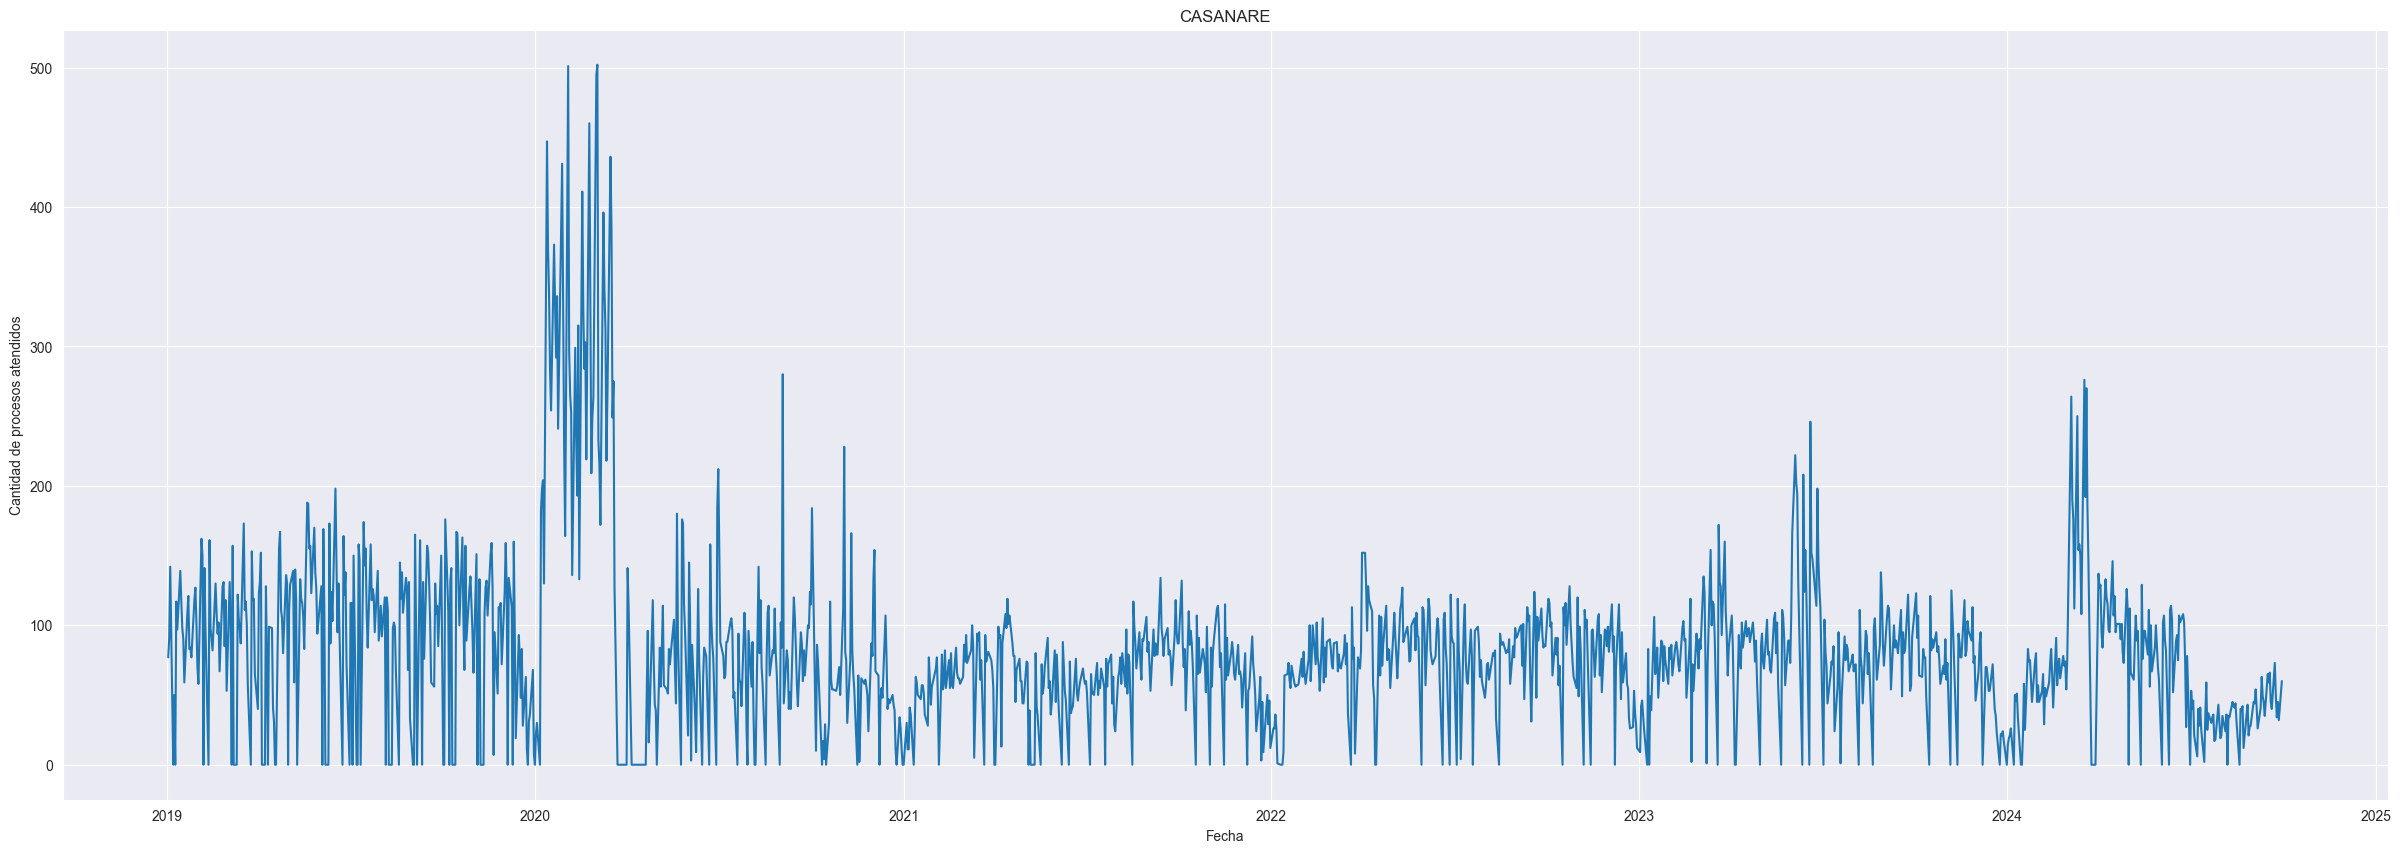

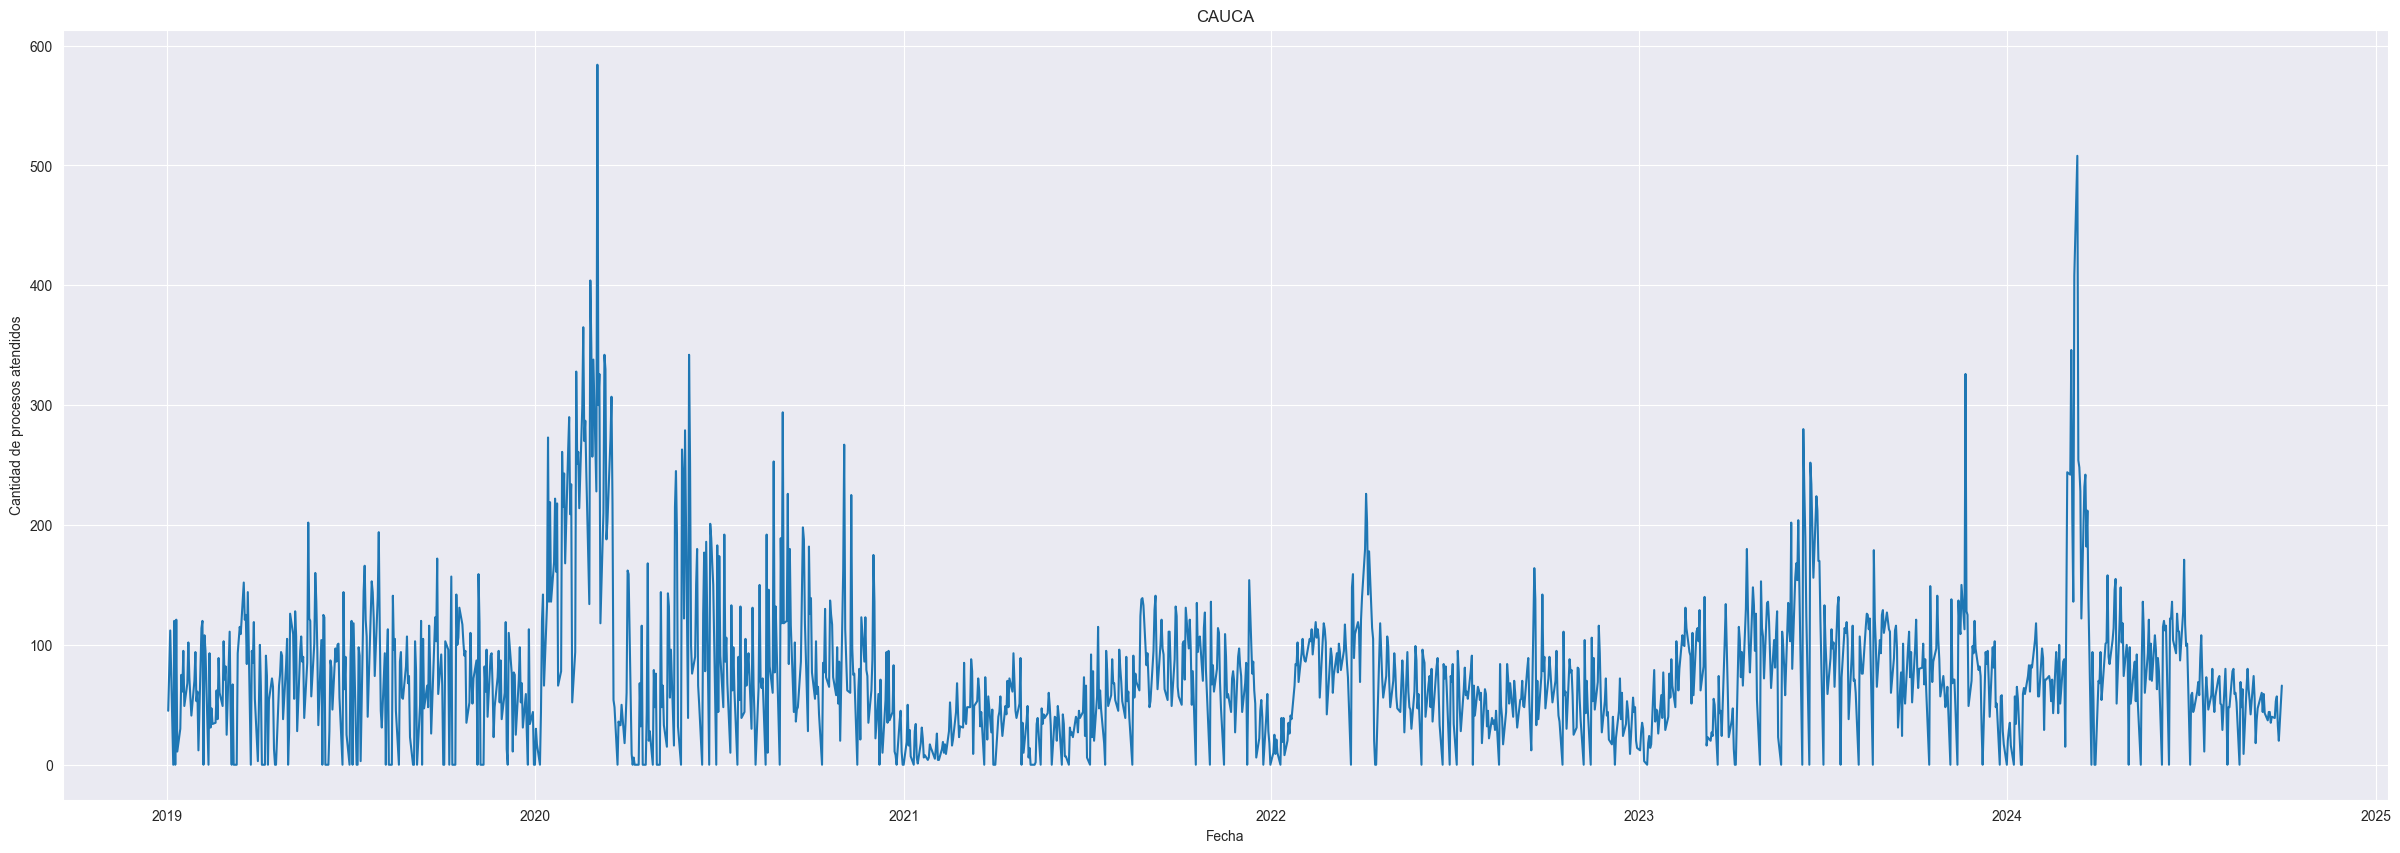

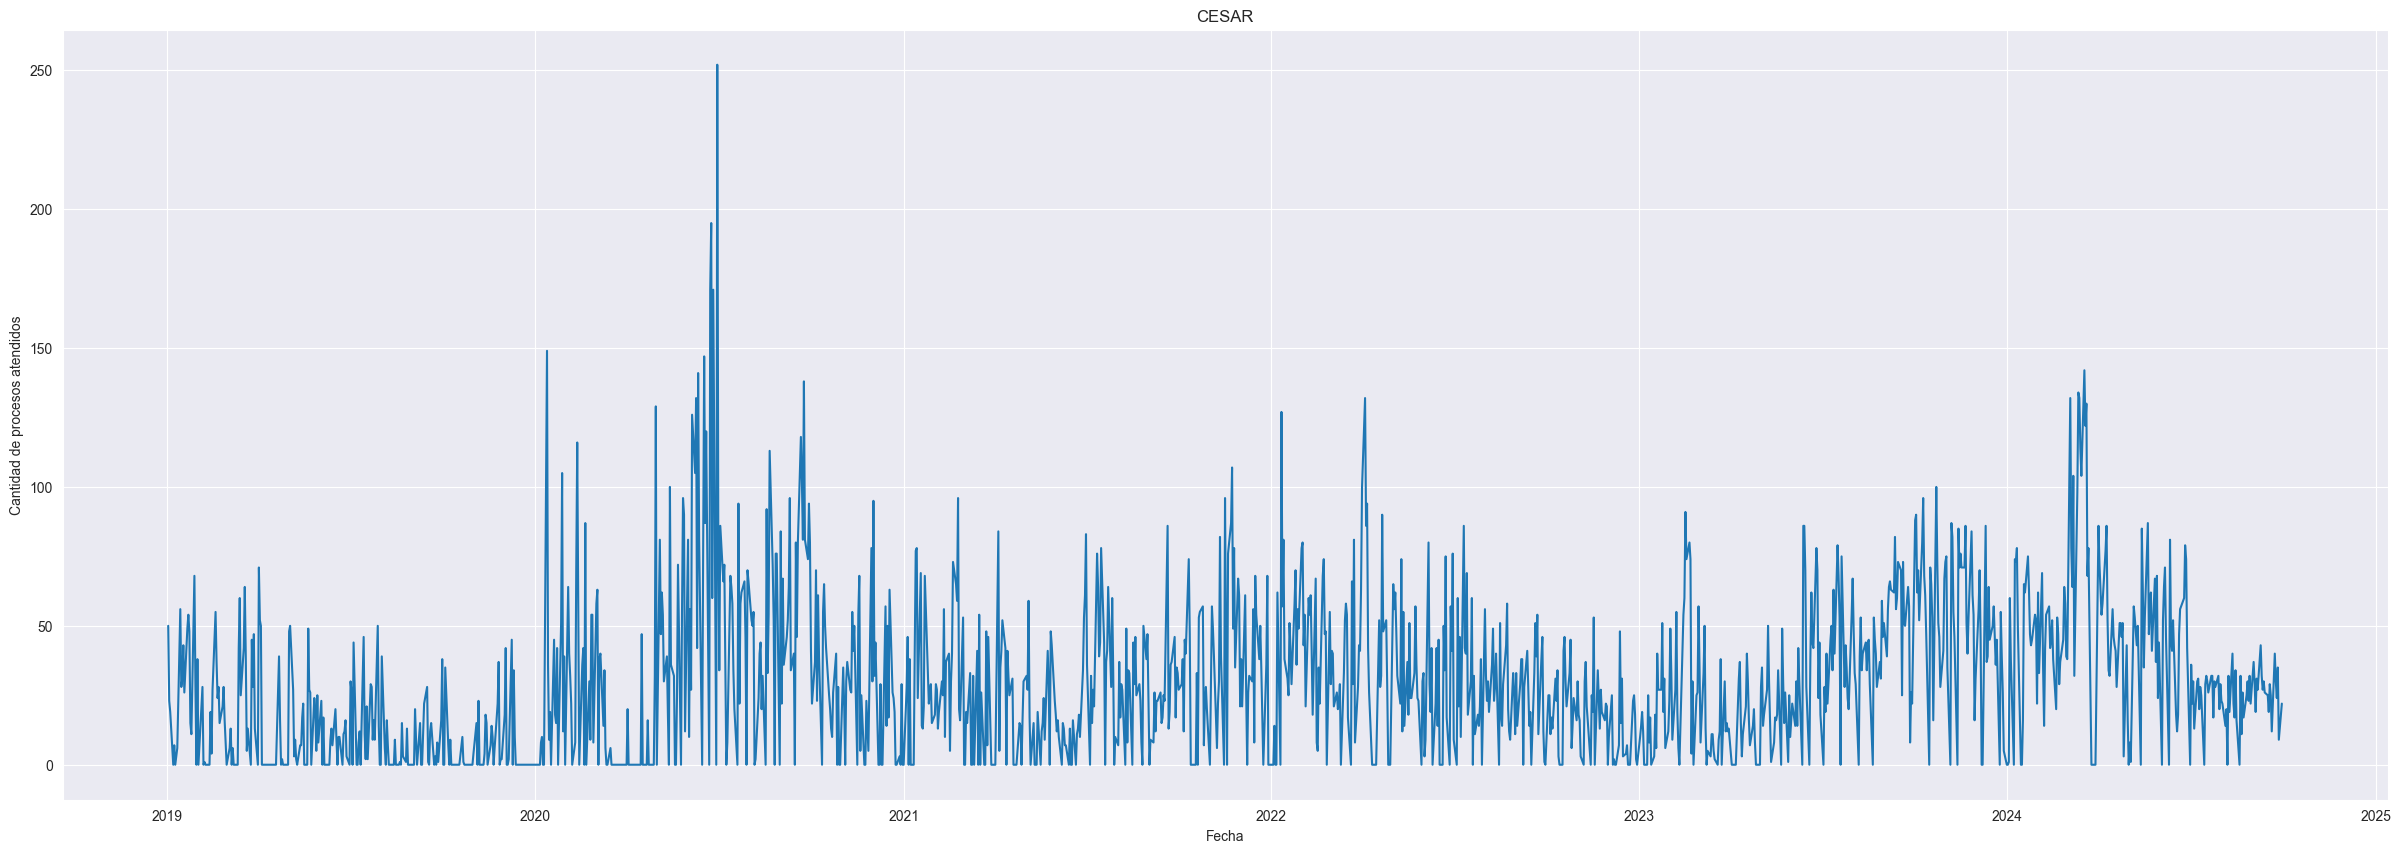

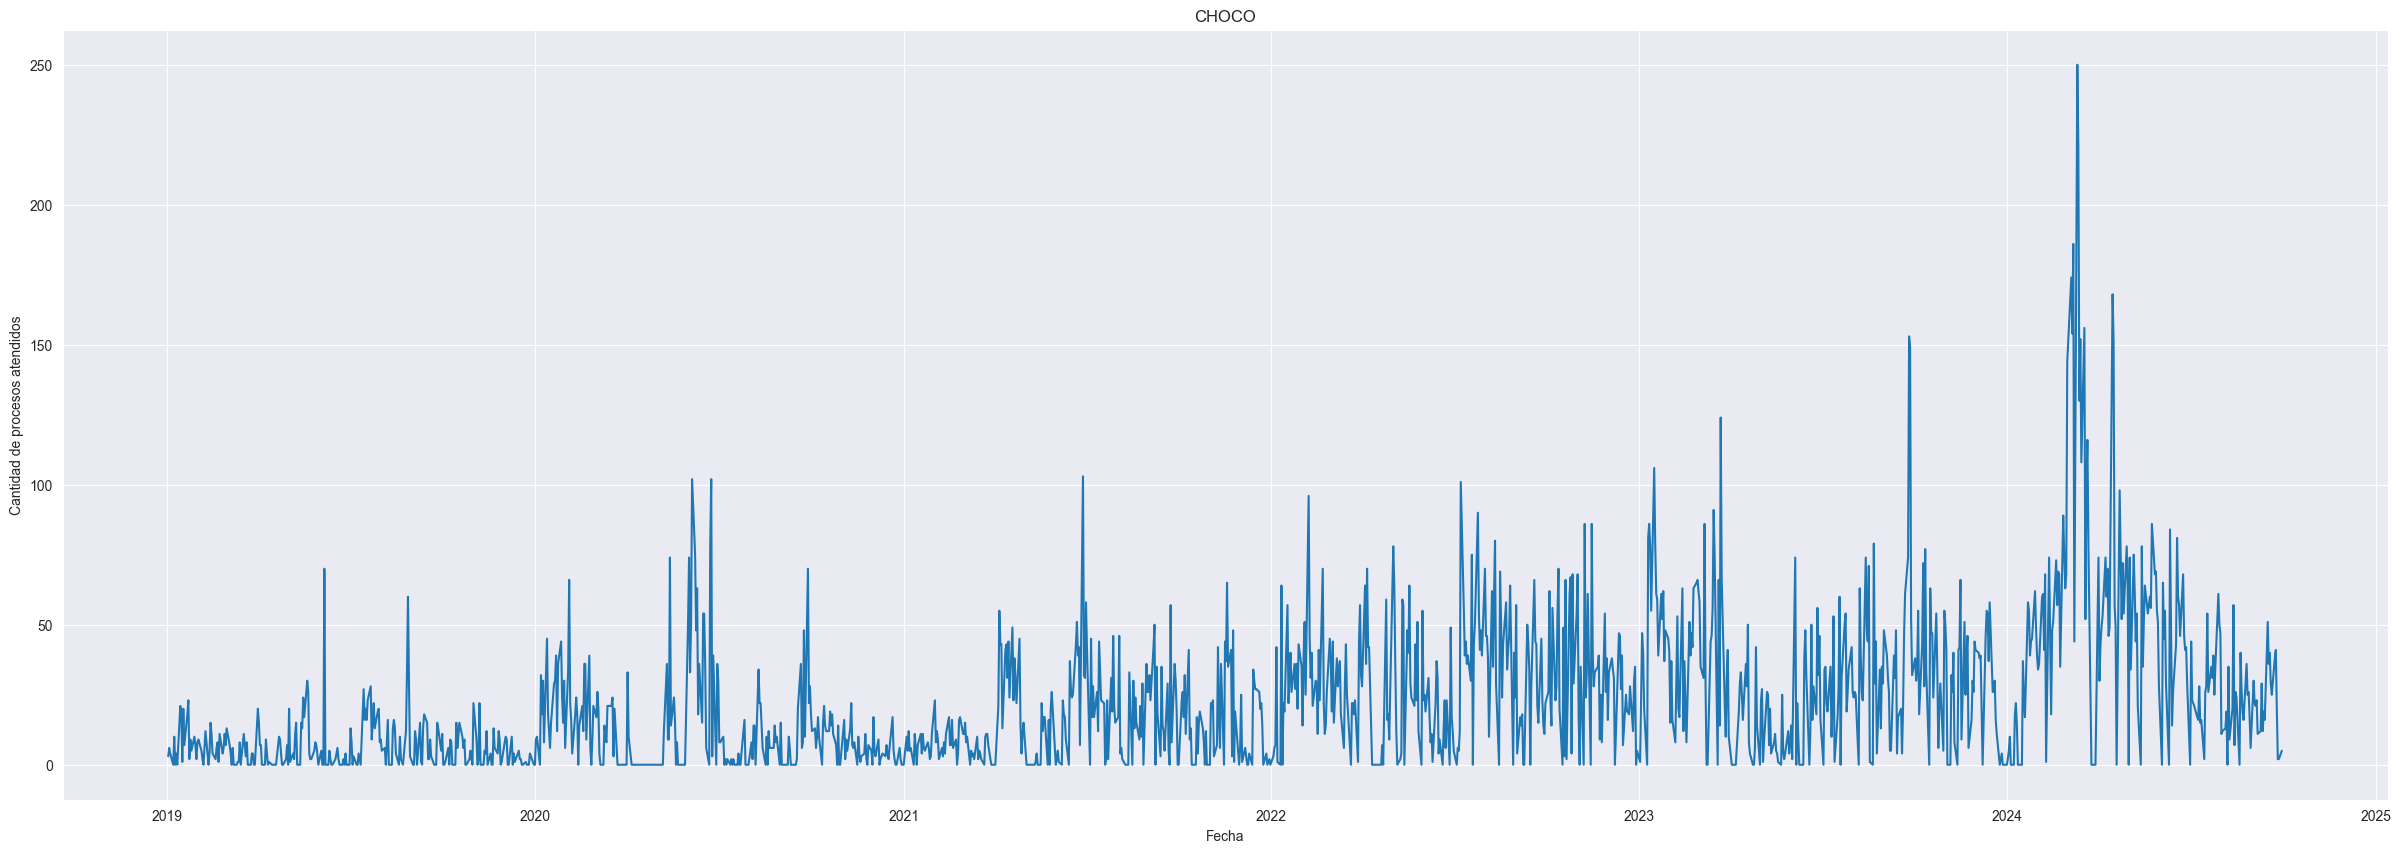

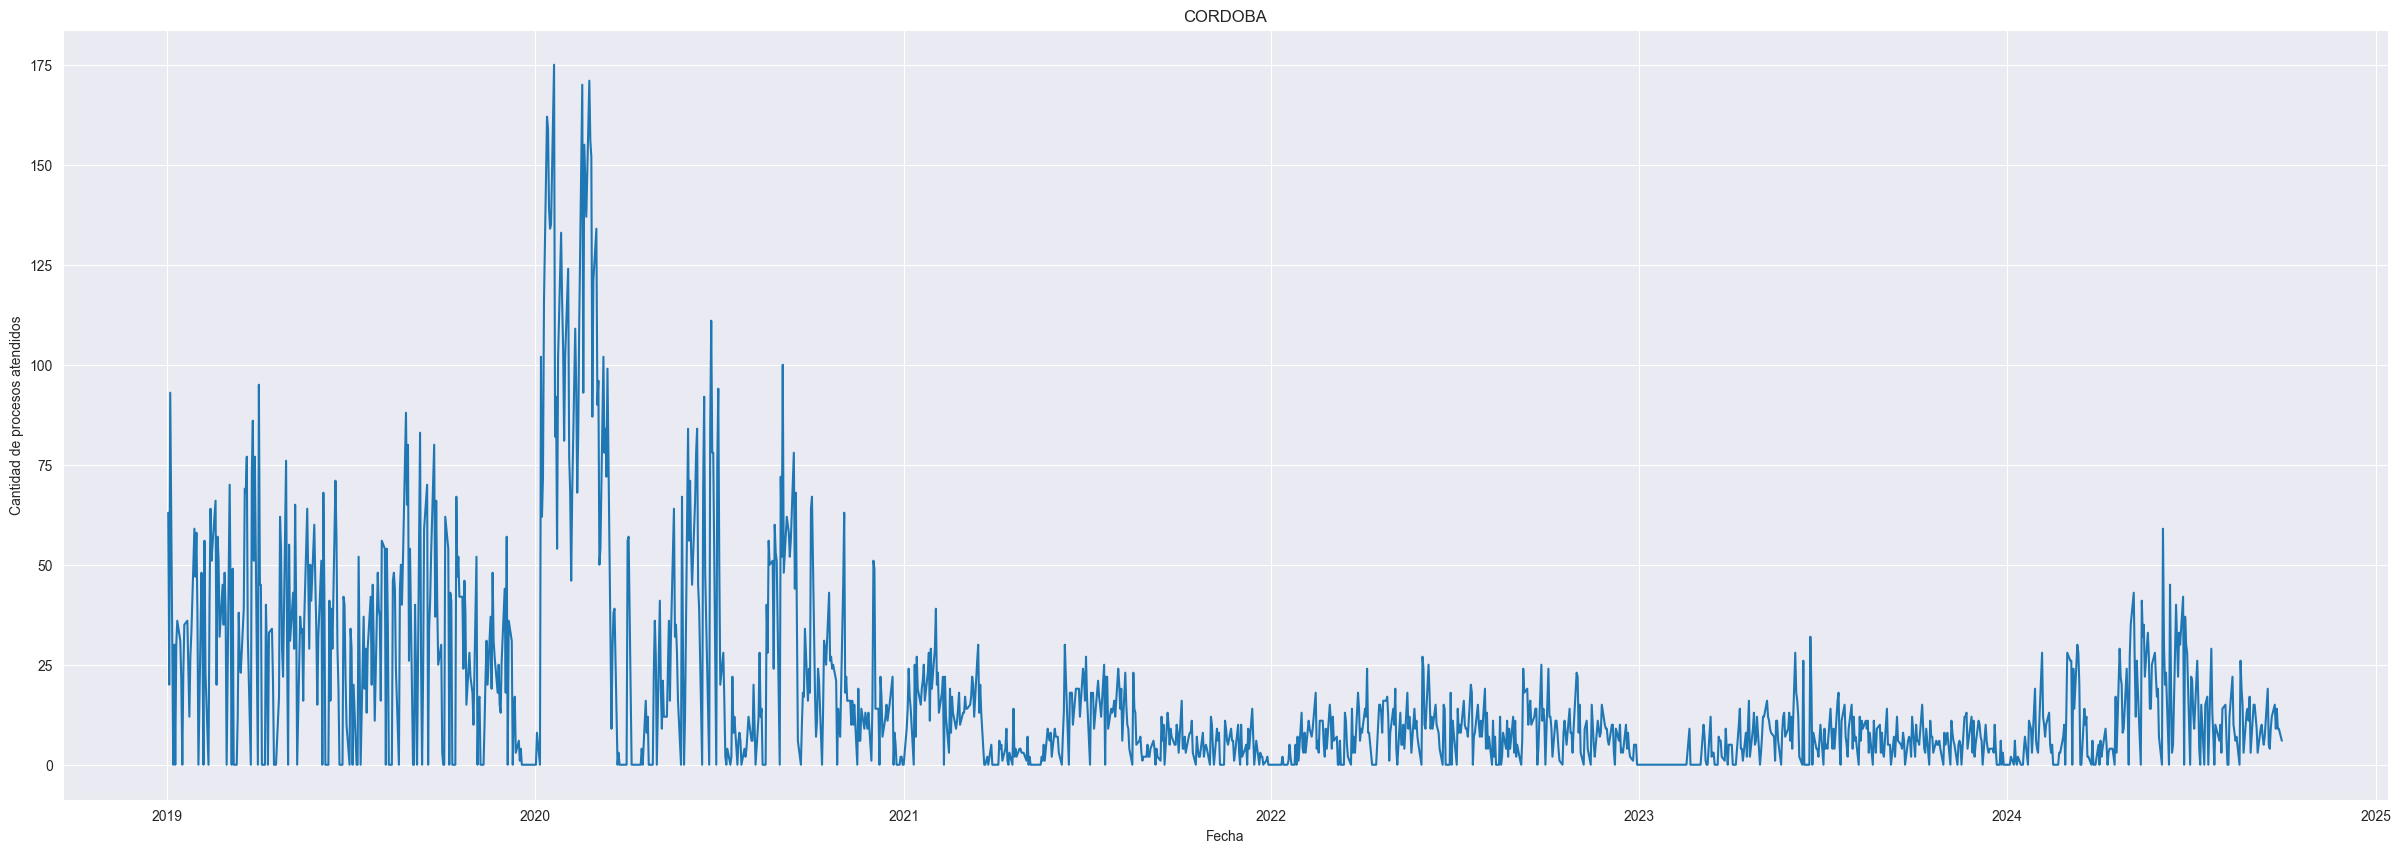

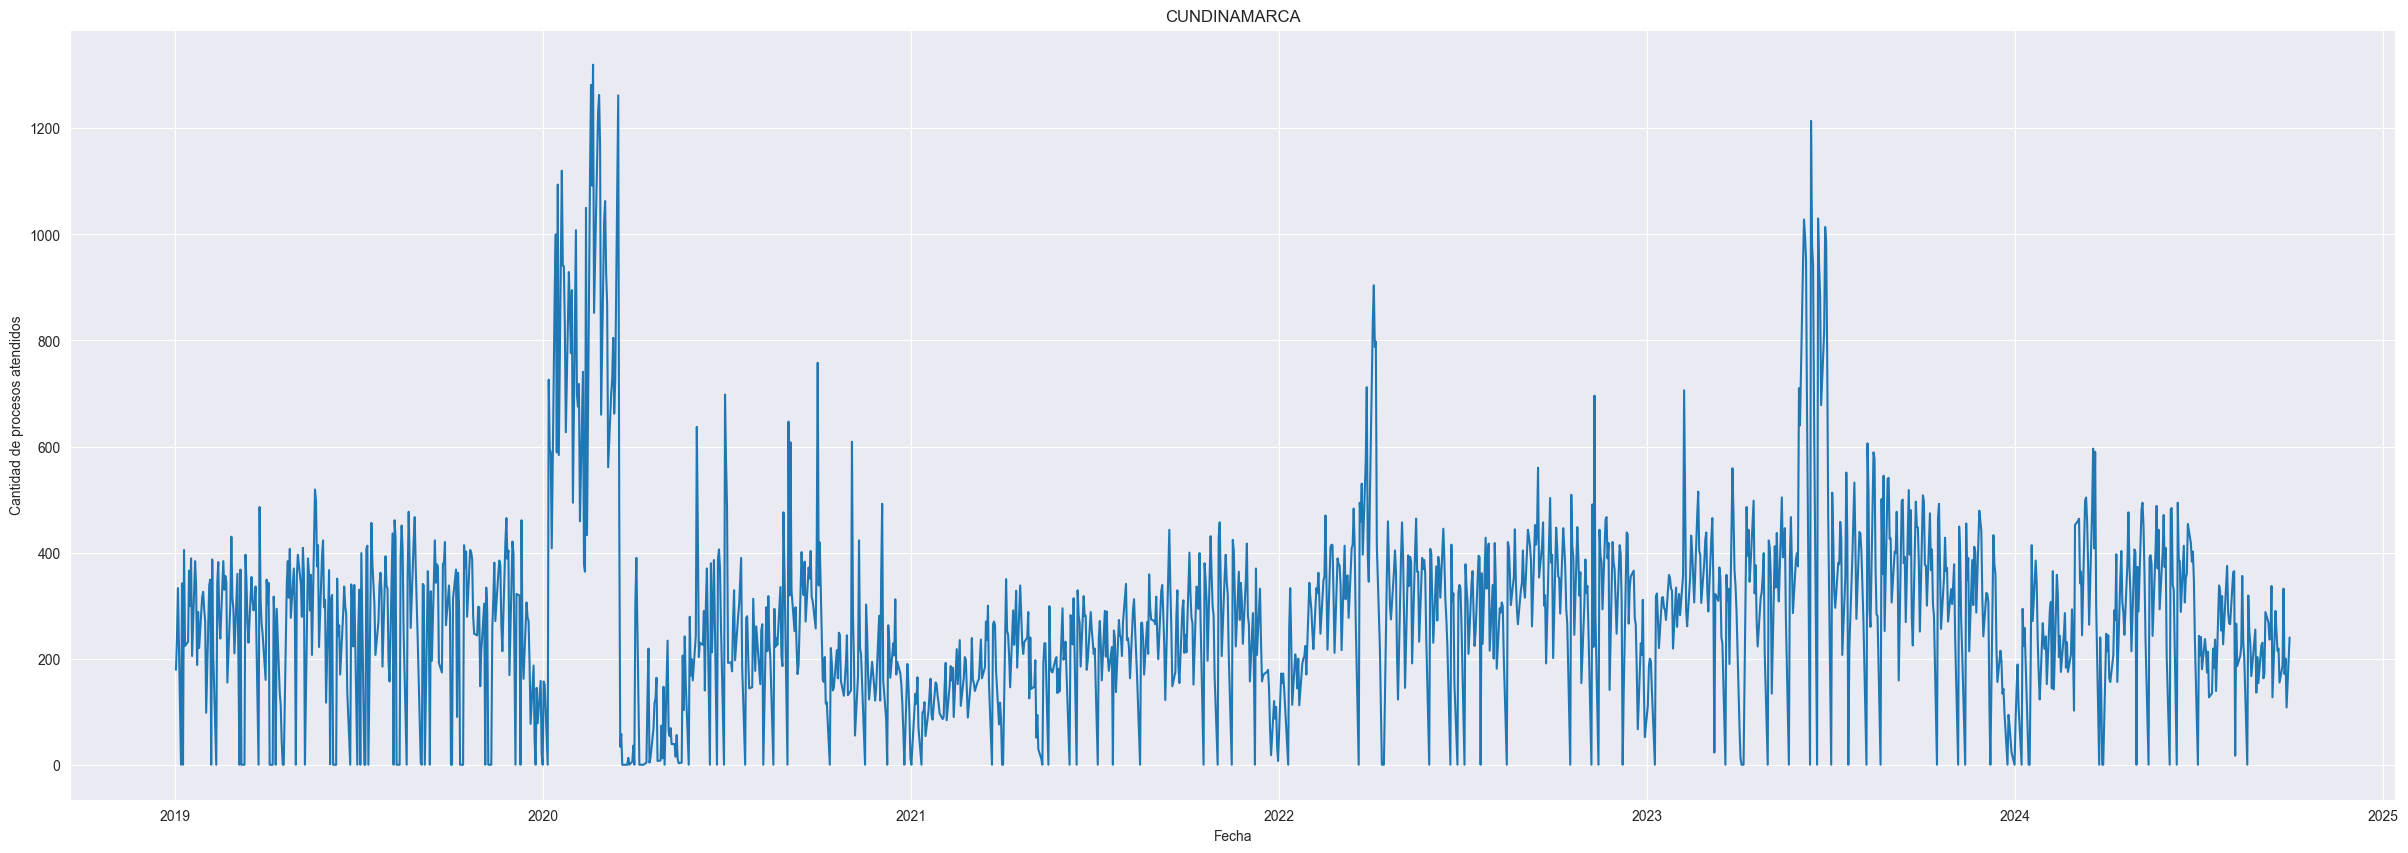

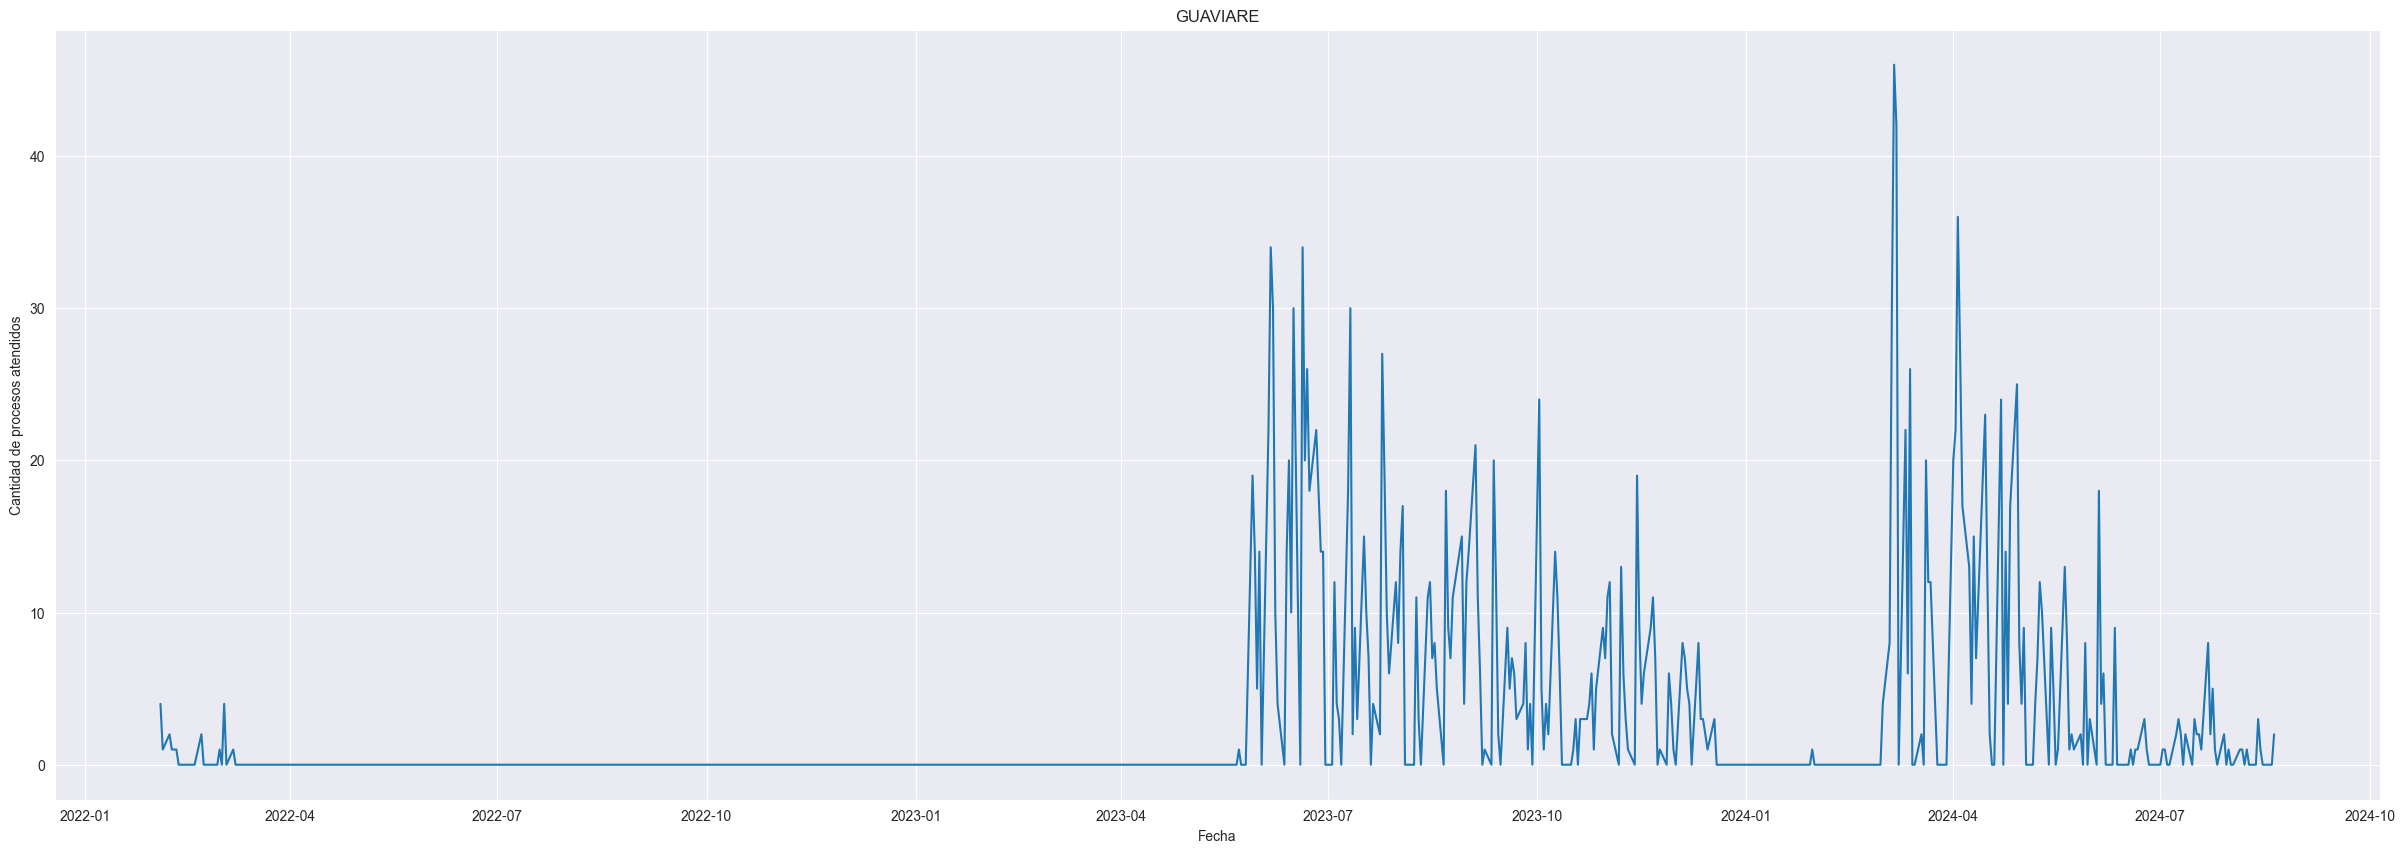

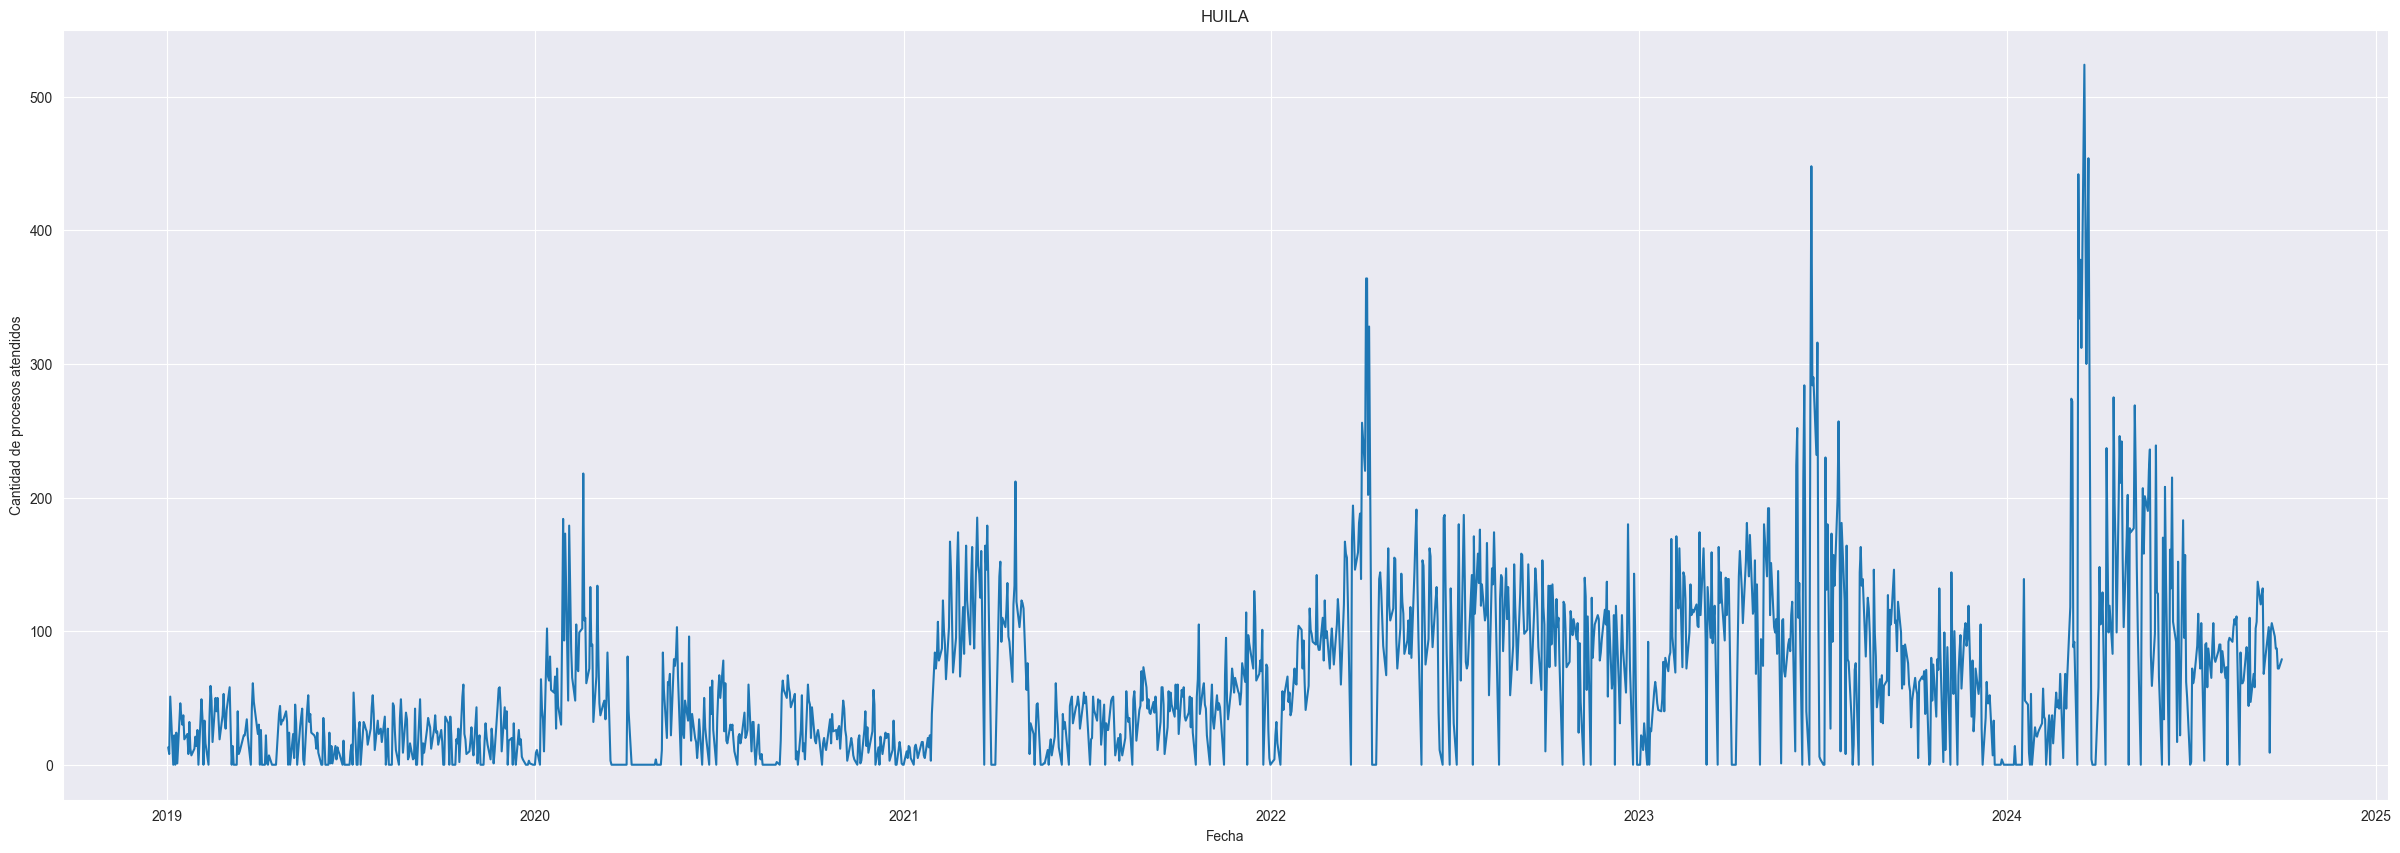

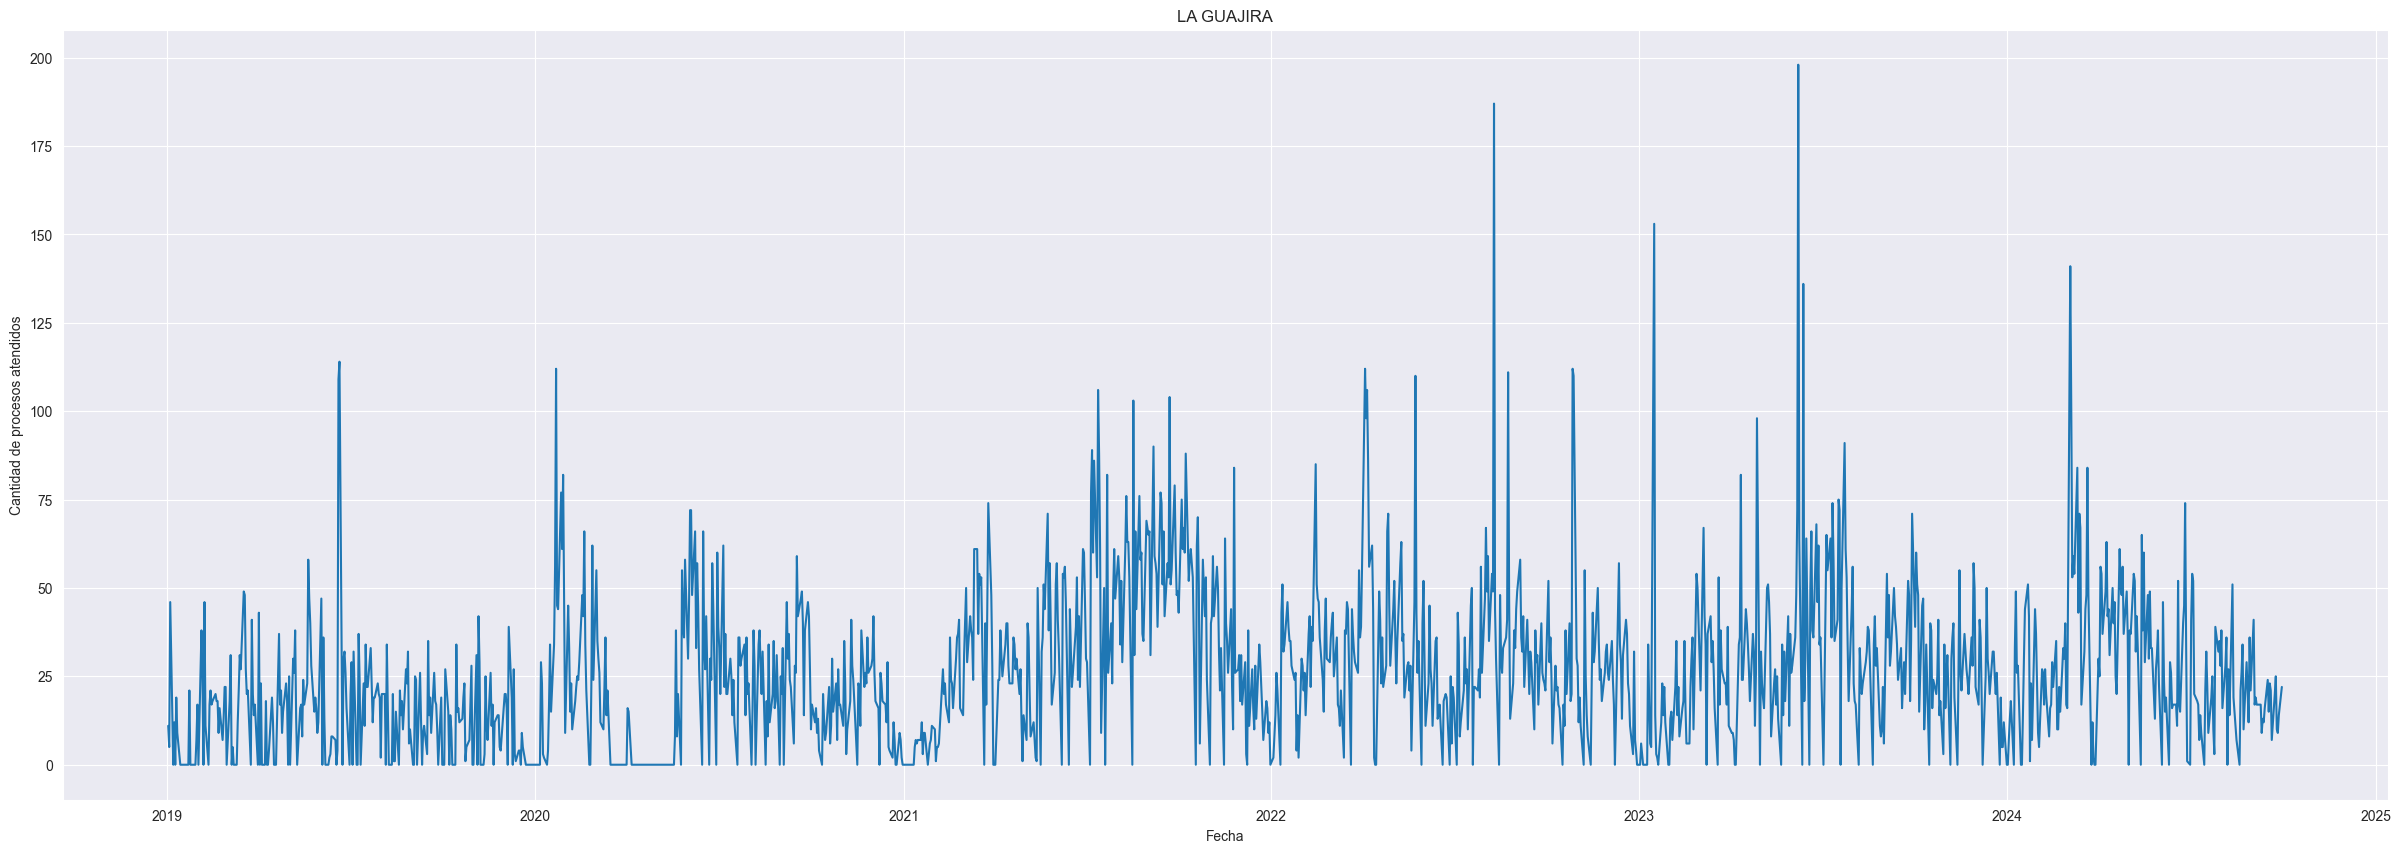

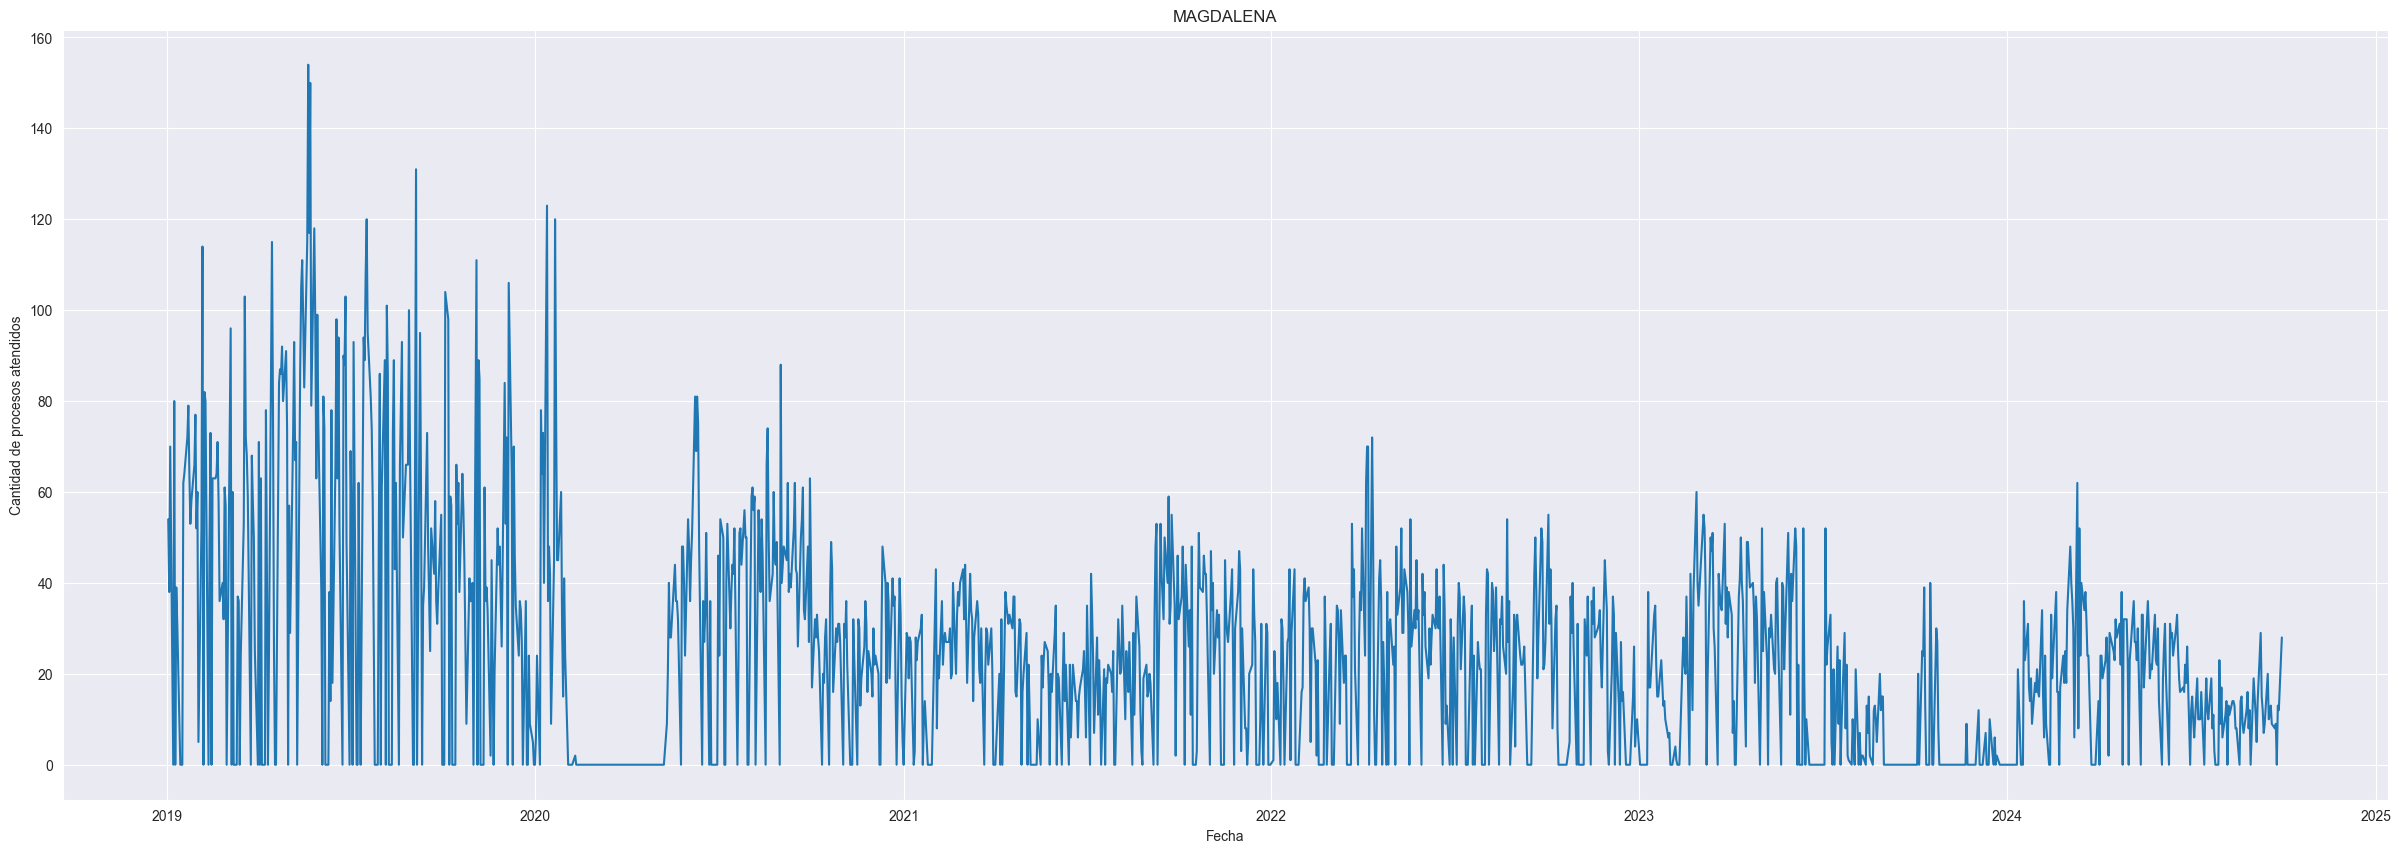

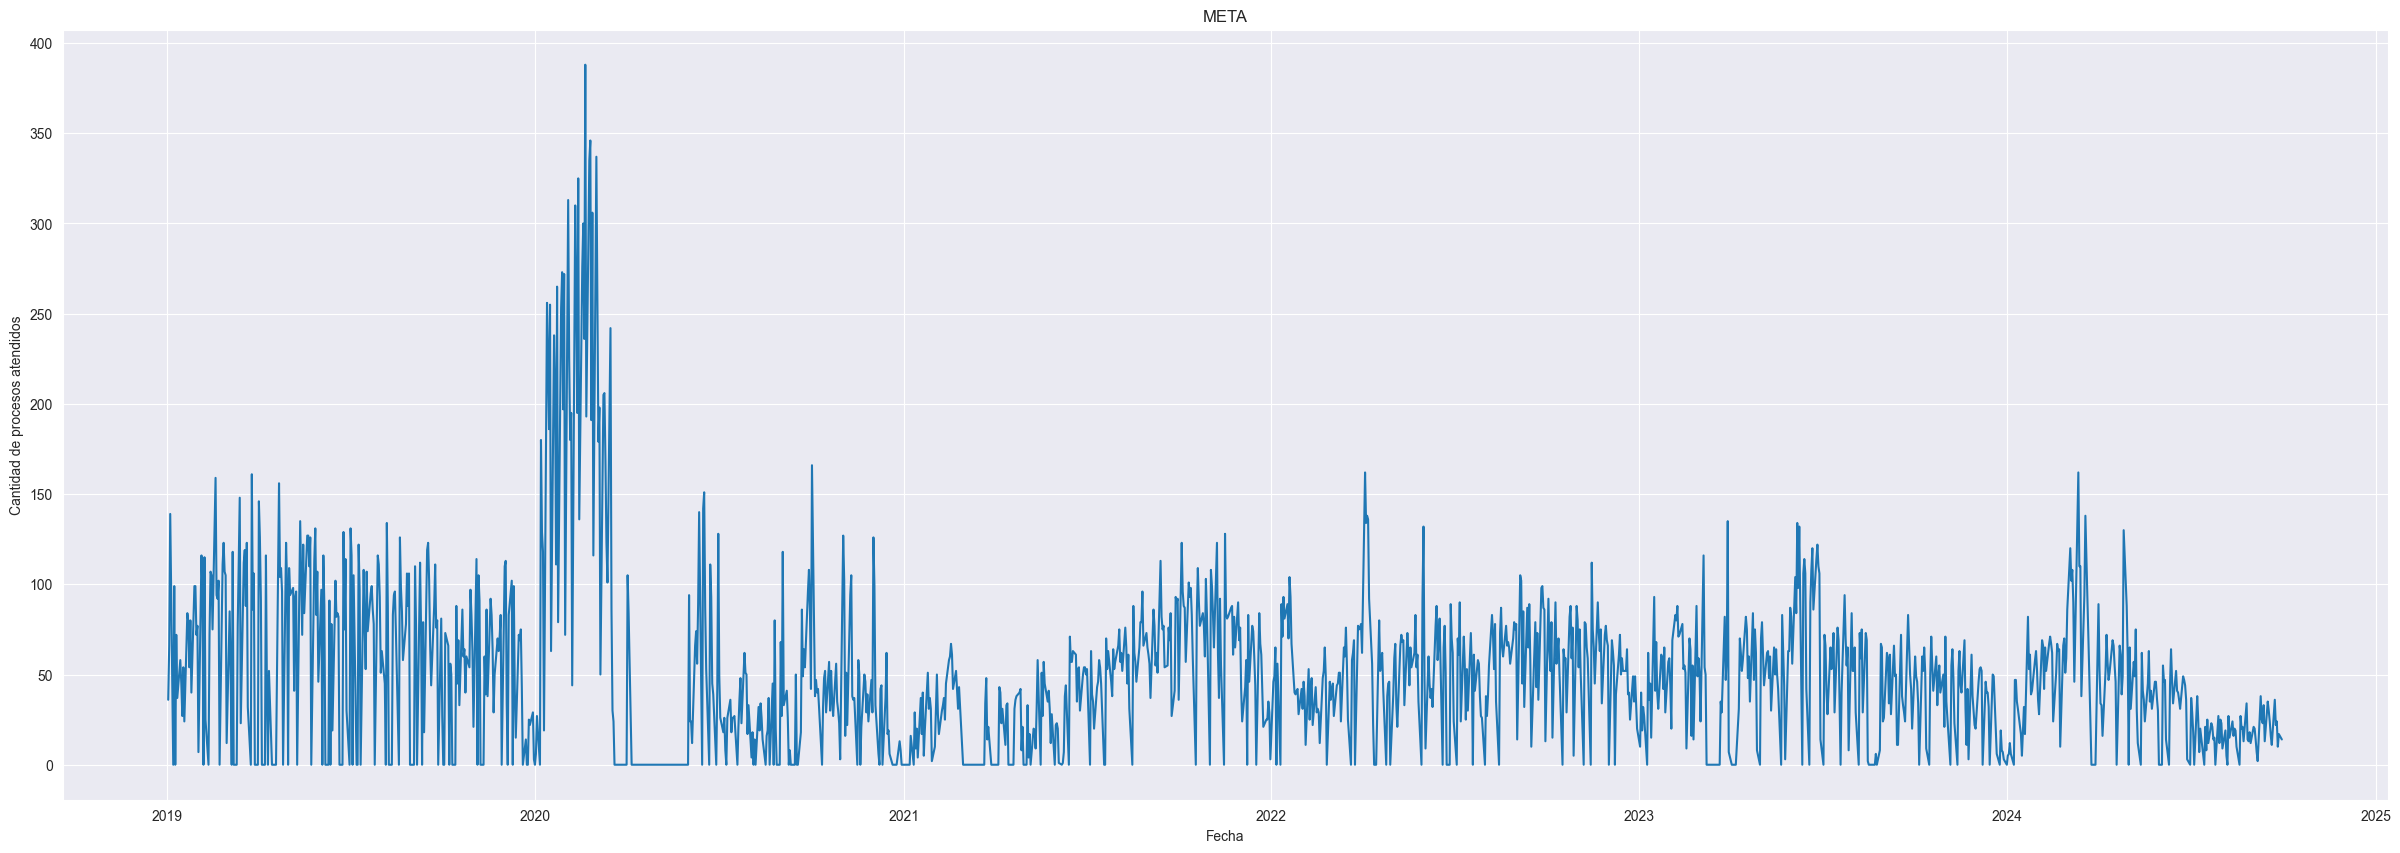

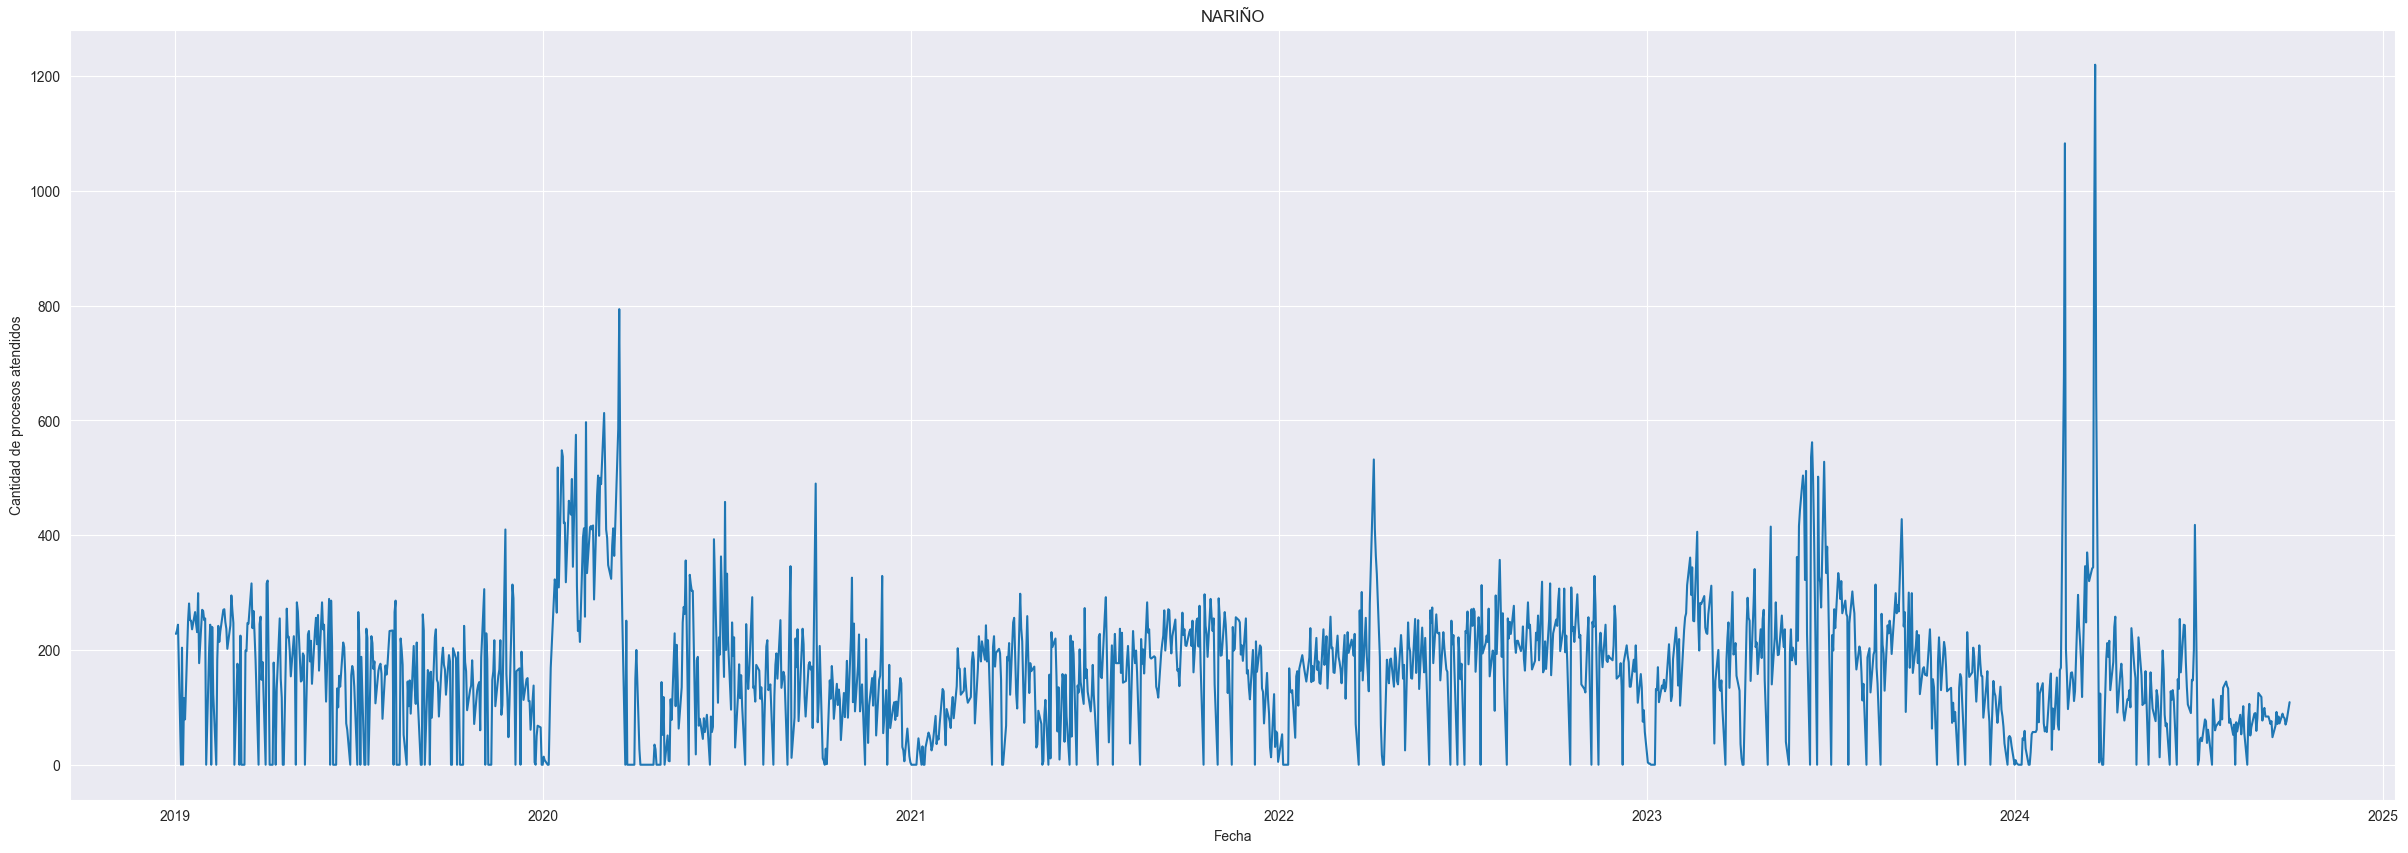

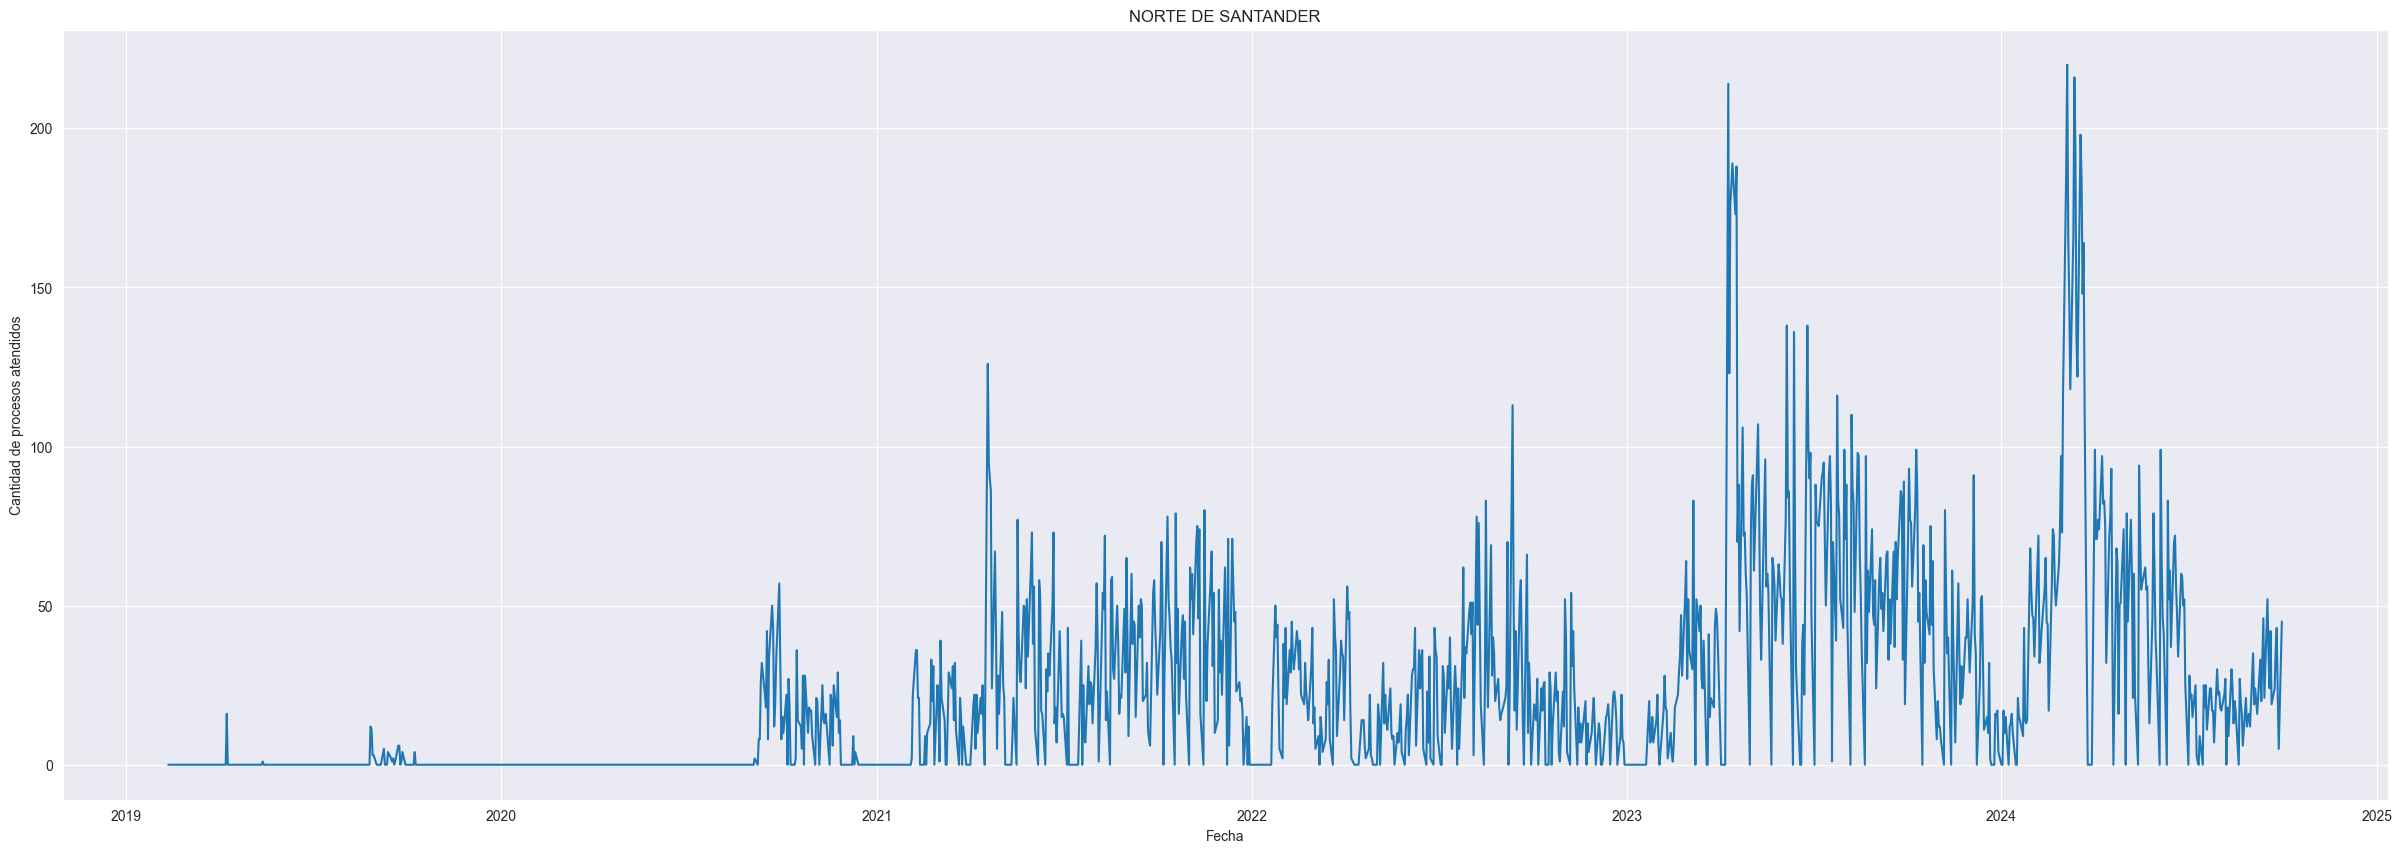

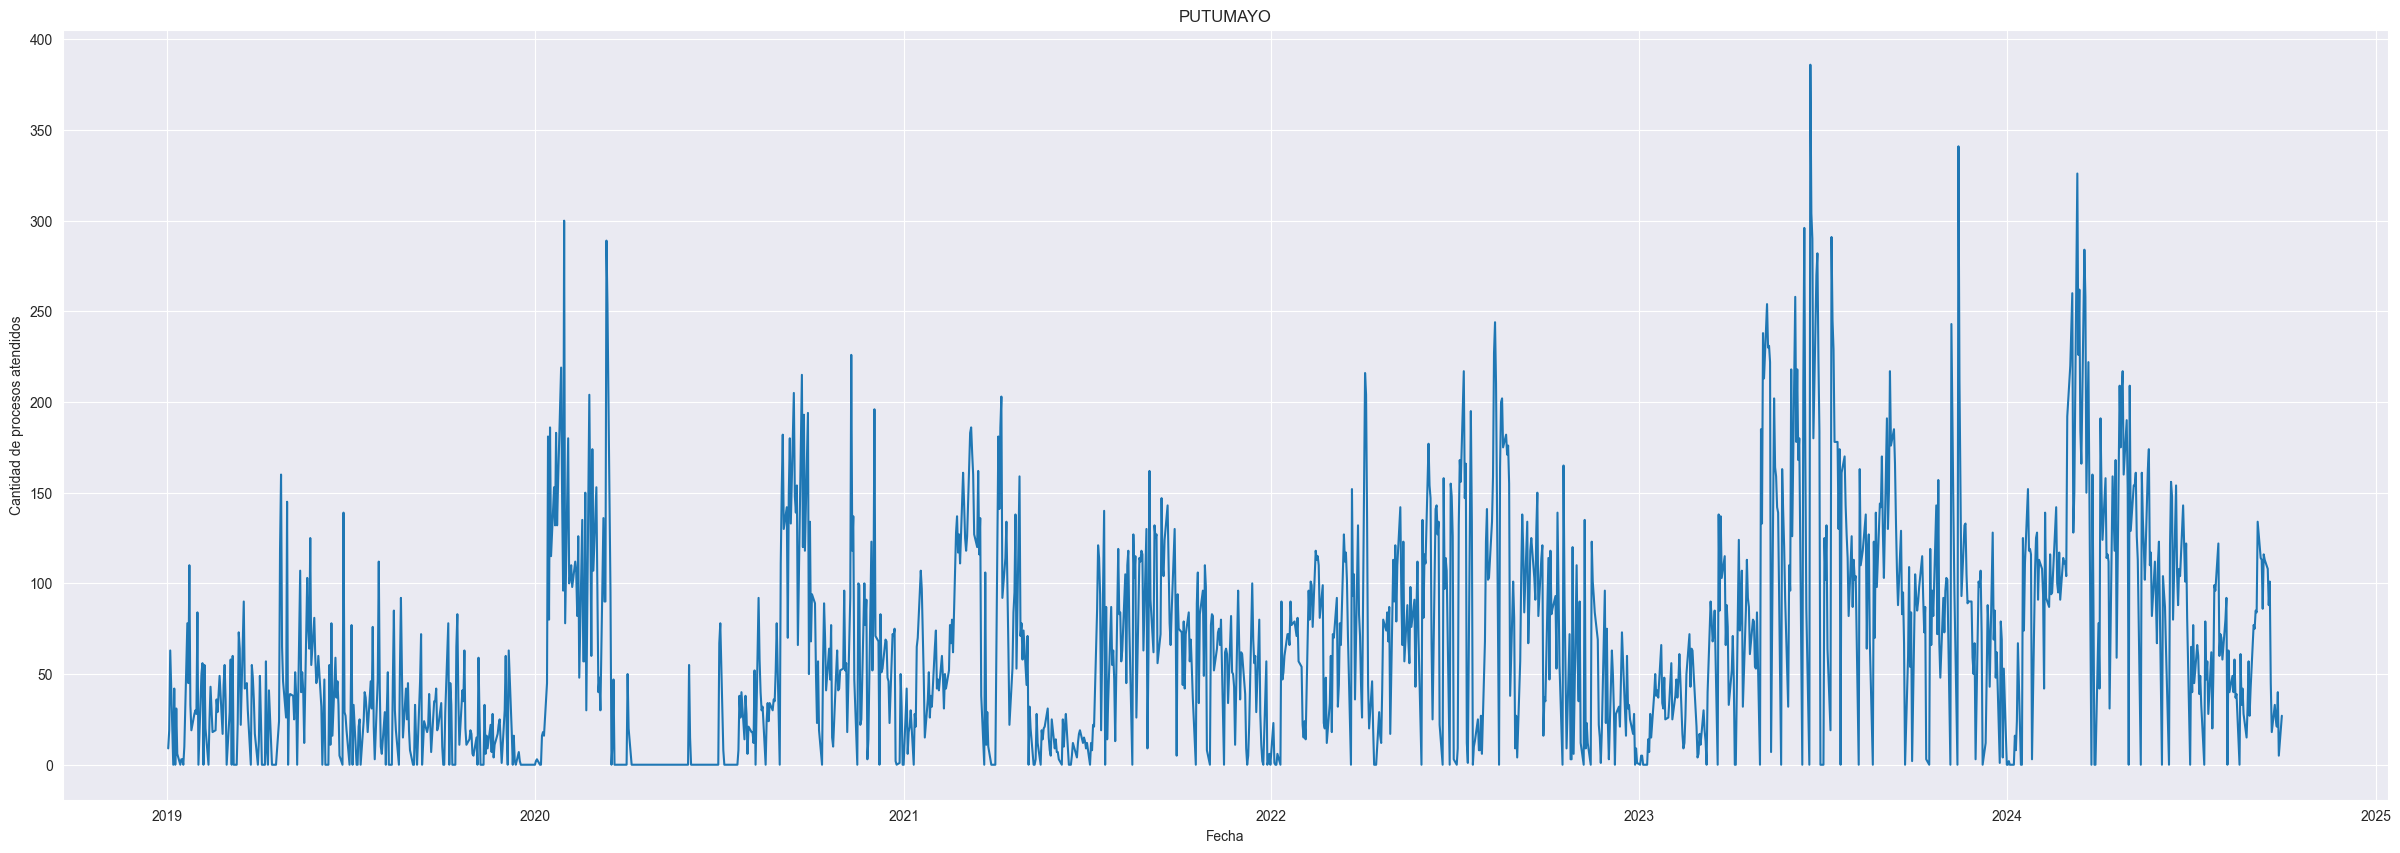

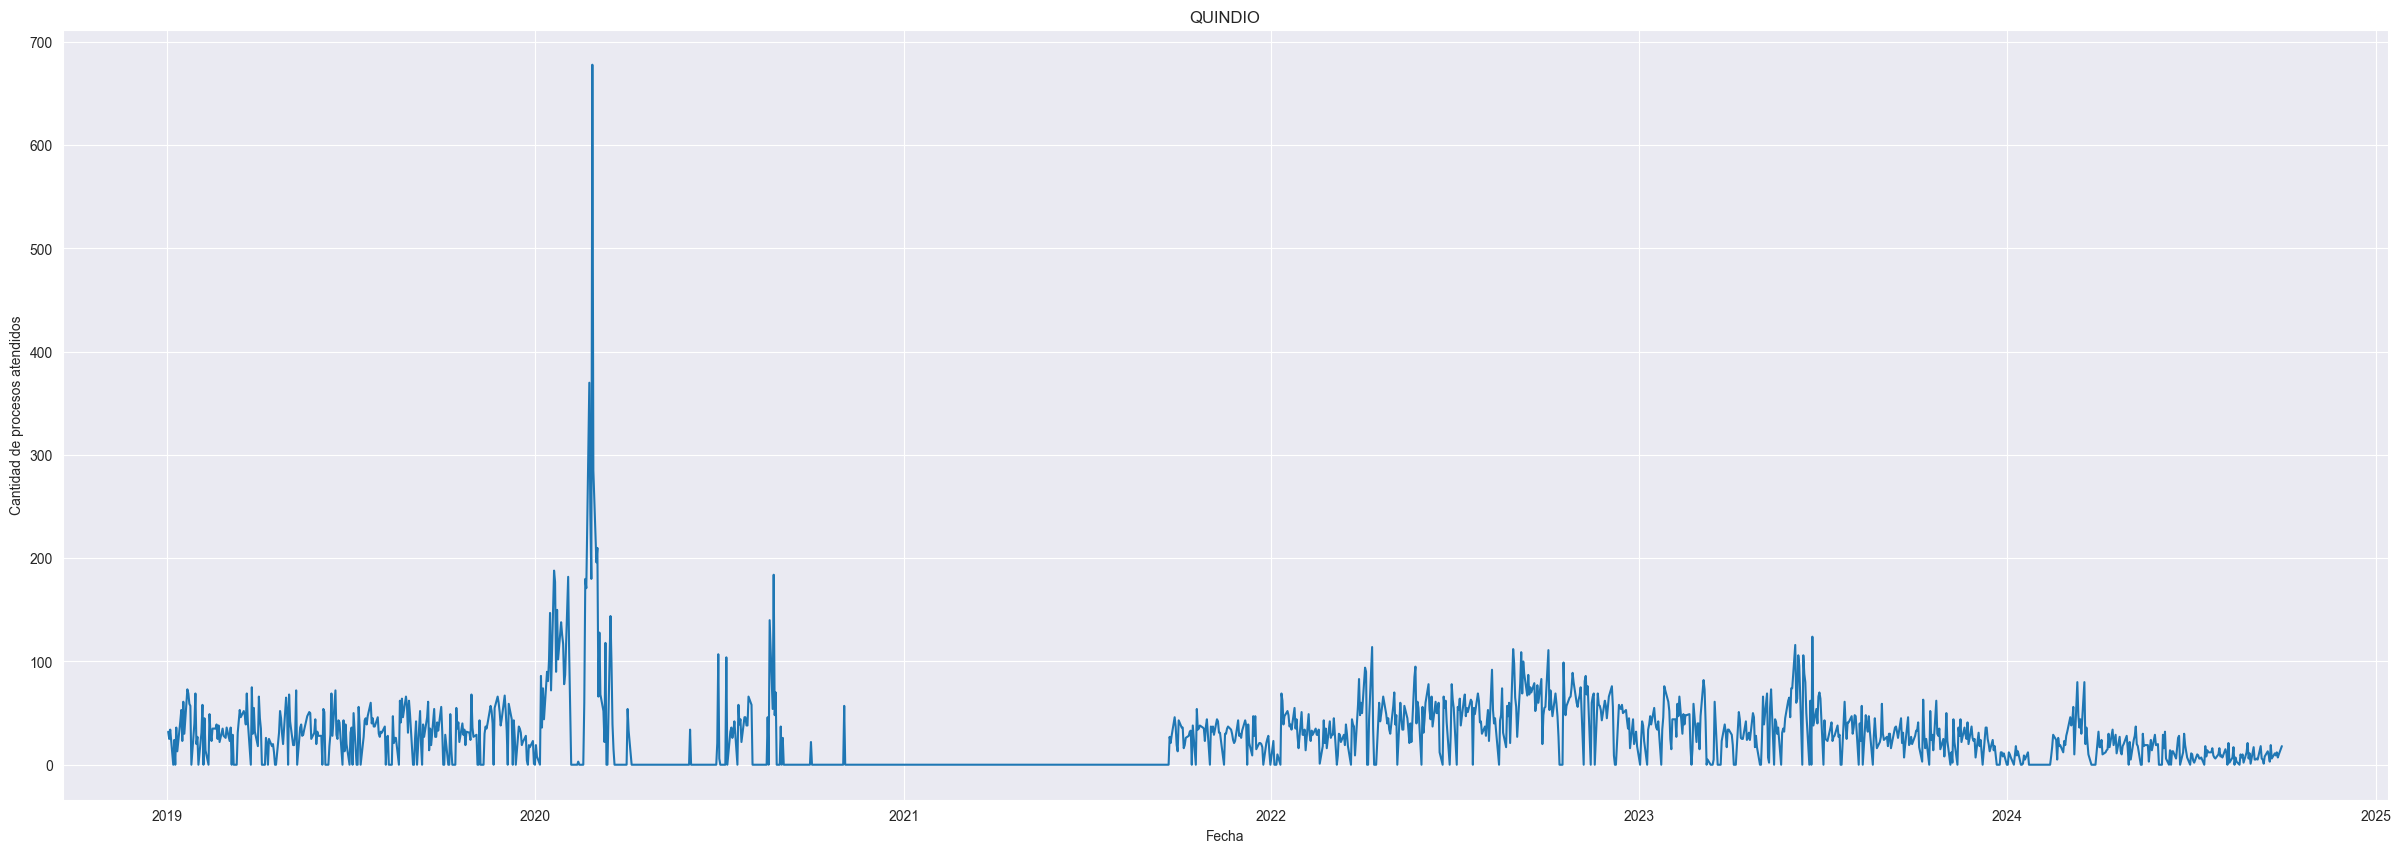

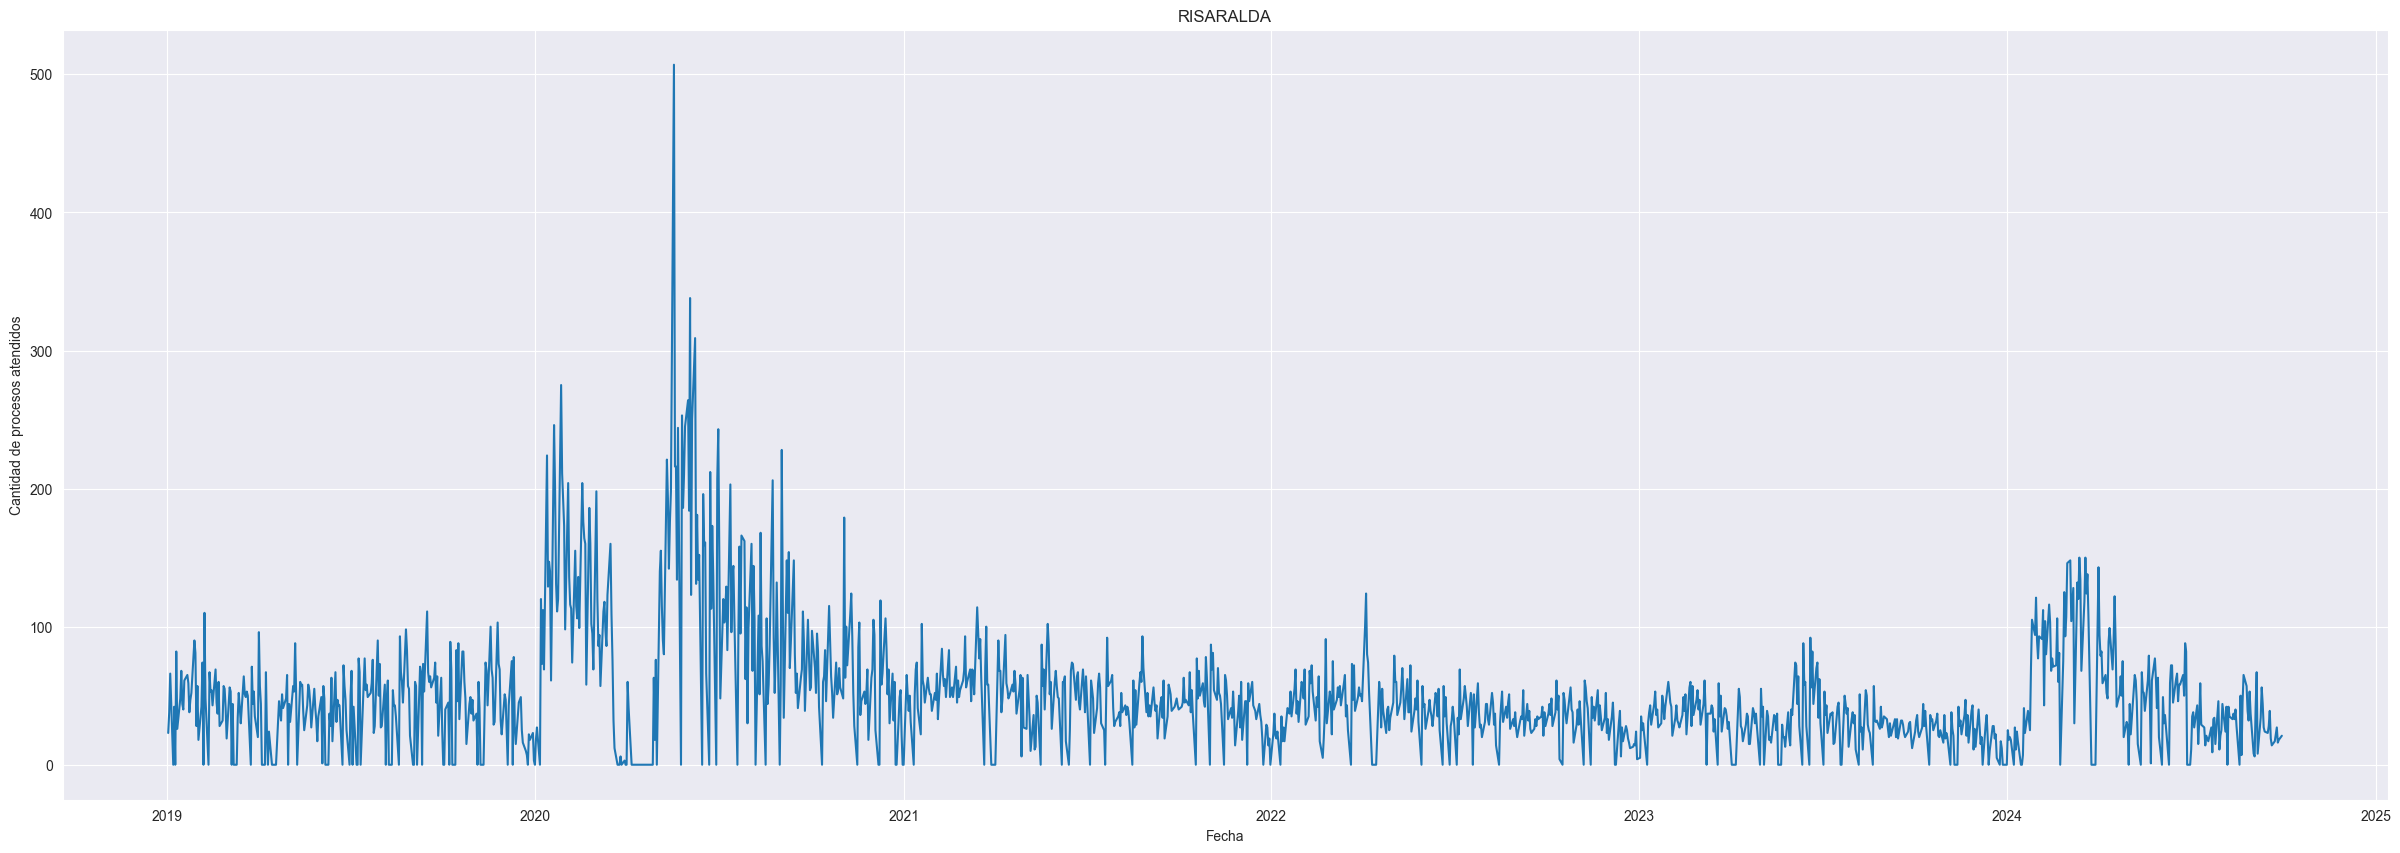

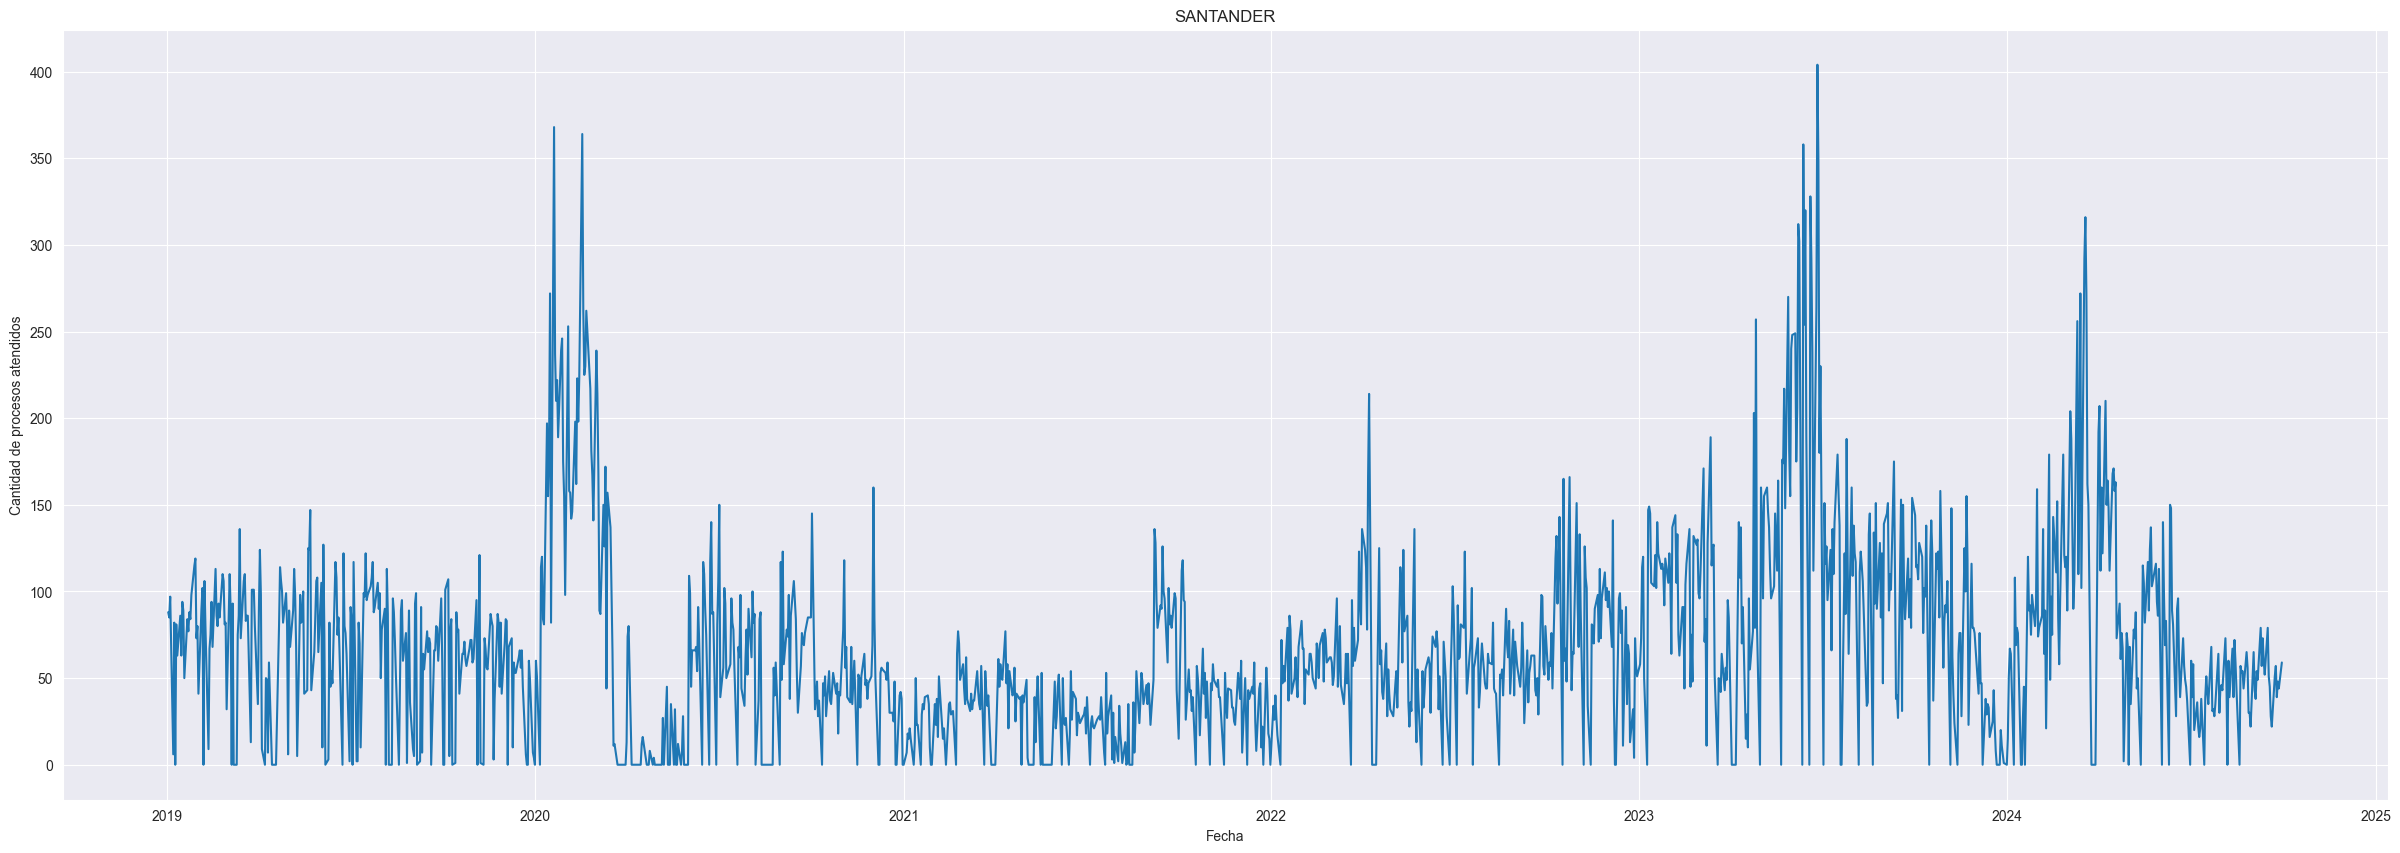

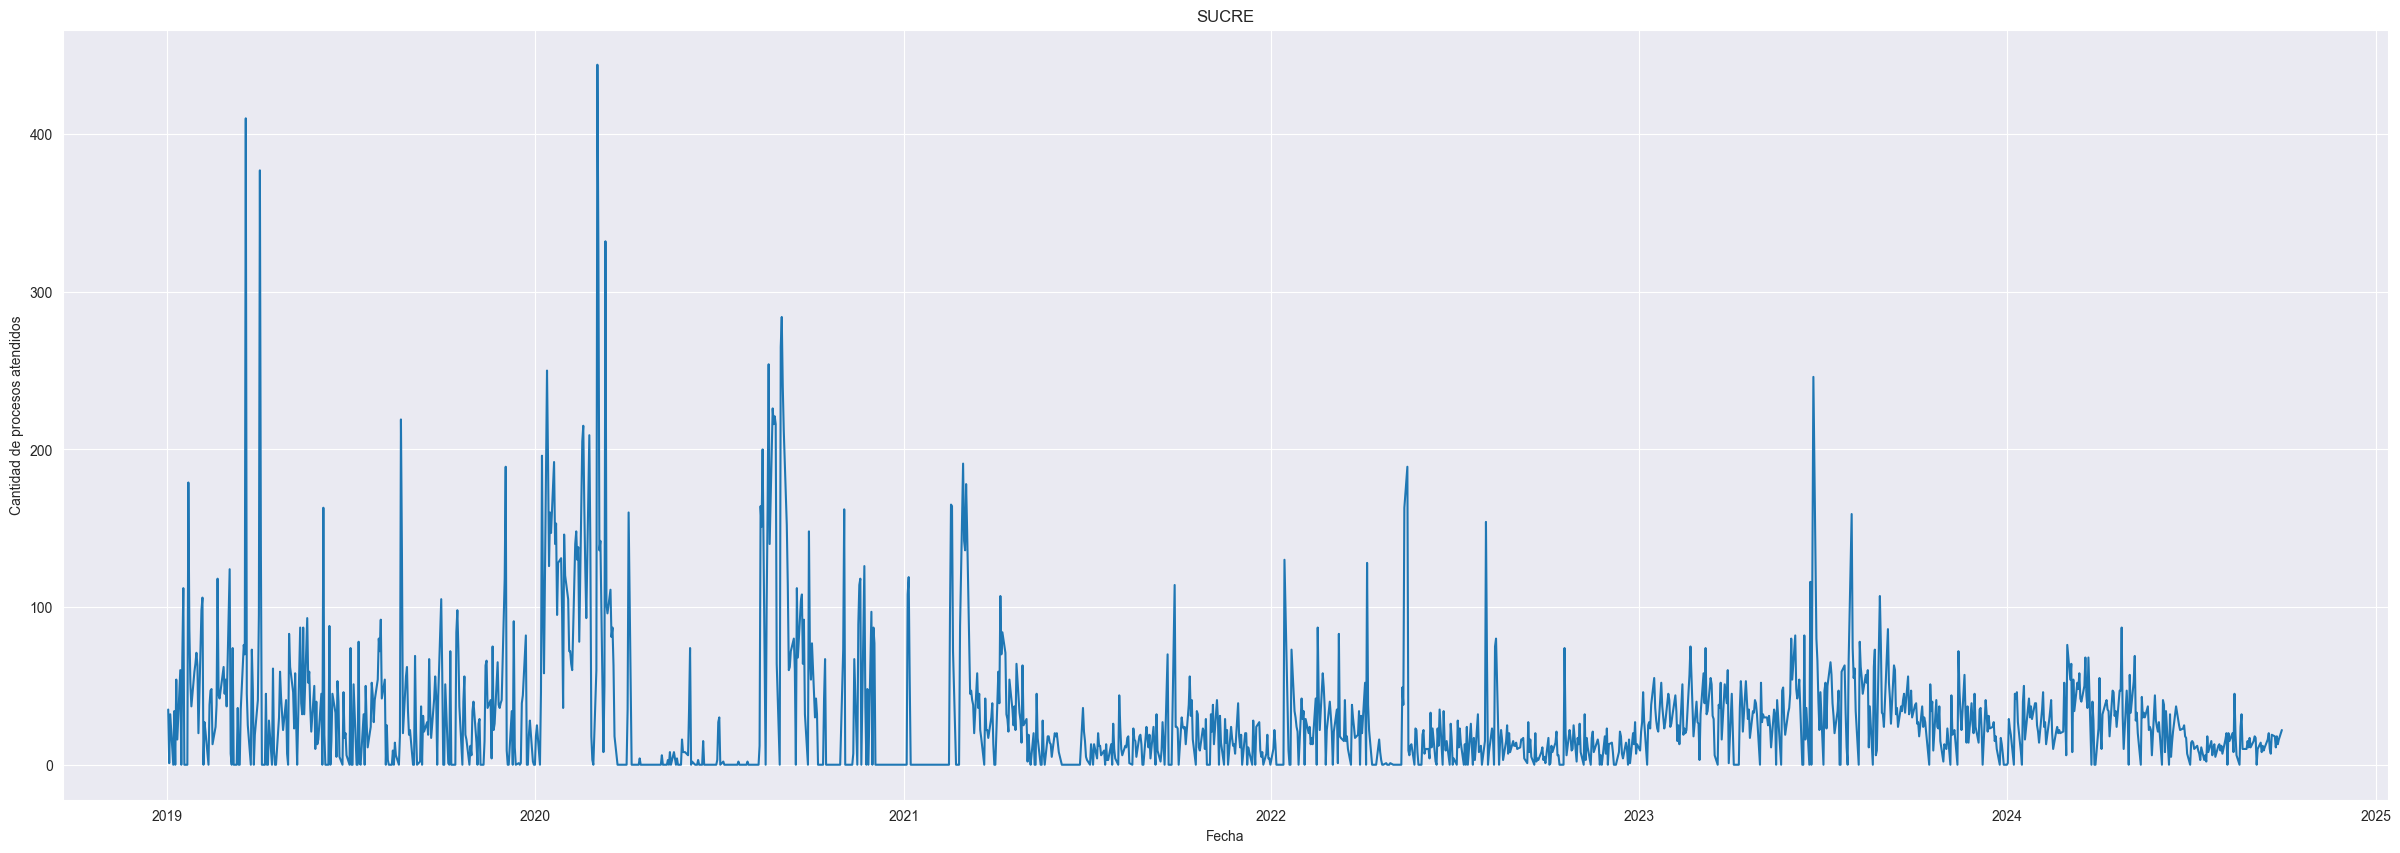

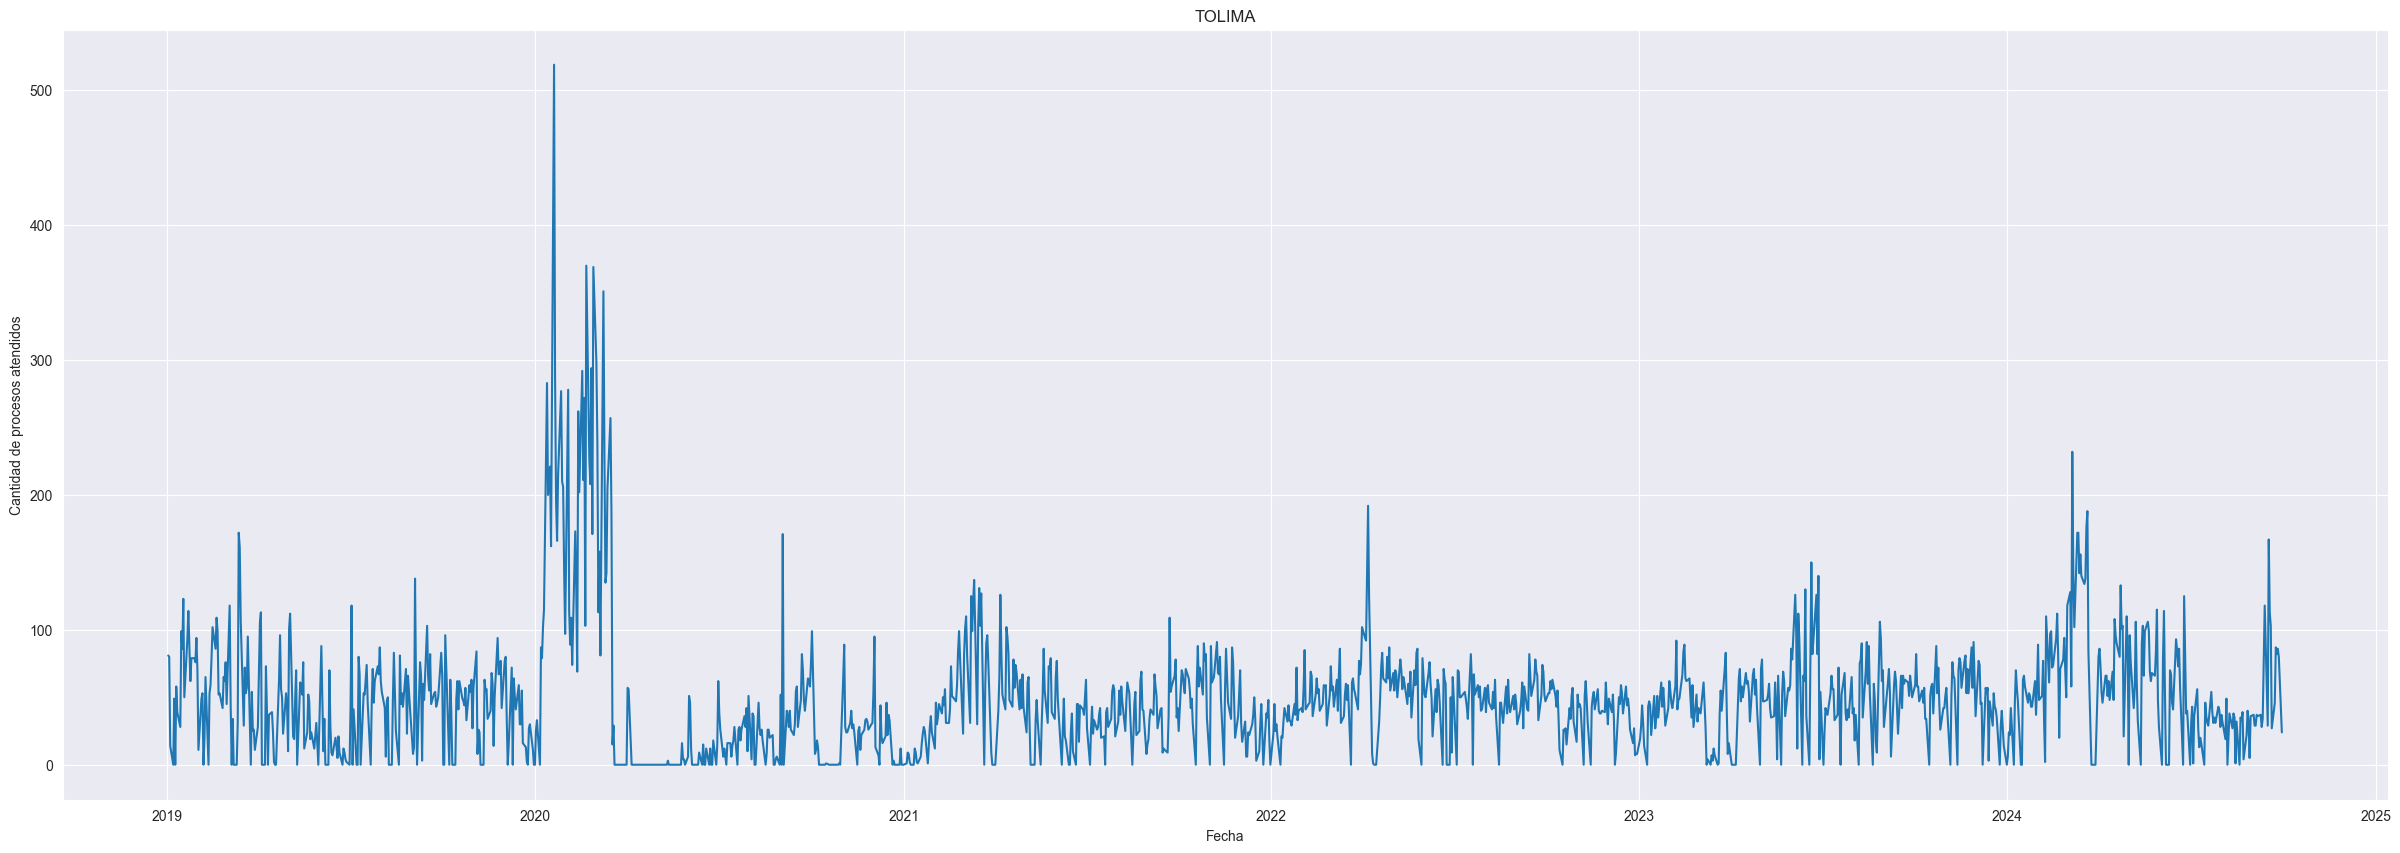

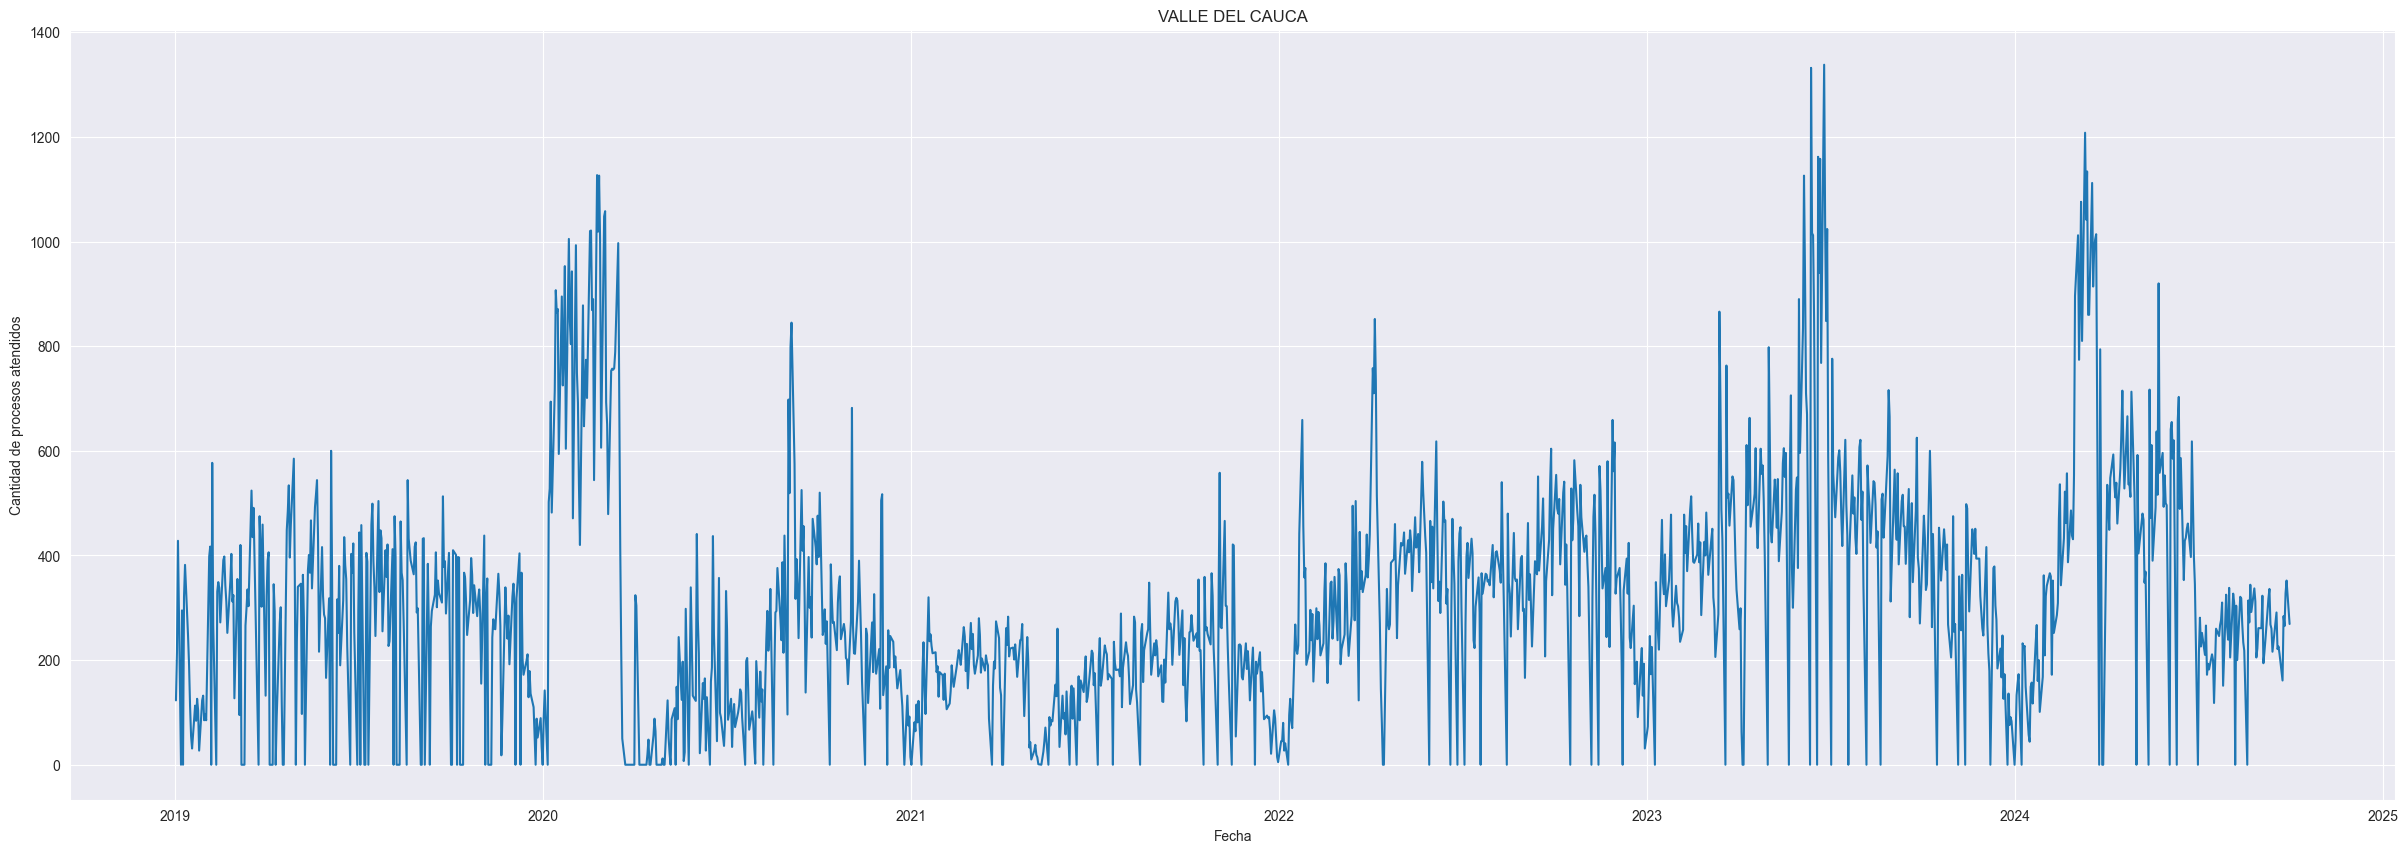

In [21]:
for key in dfs.keys():
    plt.figure(figsize=(30,10))
    plt.plot(dfs[key]['FechaSolicitud'].values, dfs[key]['CantidadCasos'].values)
    plt.title(key)
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de procesos atendidos')
    plt.show()
    

In [8]:
departamentos = dfs.keys()
cantidad = []
for key in dfs.keys():
    cantidad.append(sum(dfs[key]['CantidadCasos'].values))

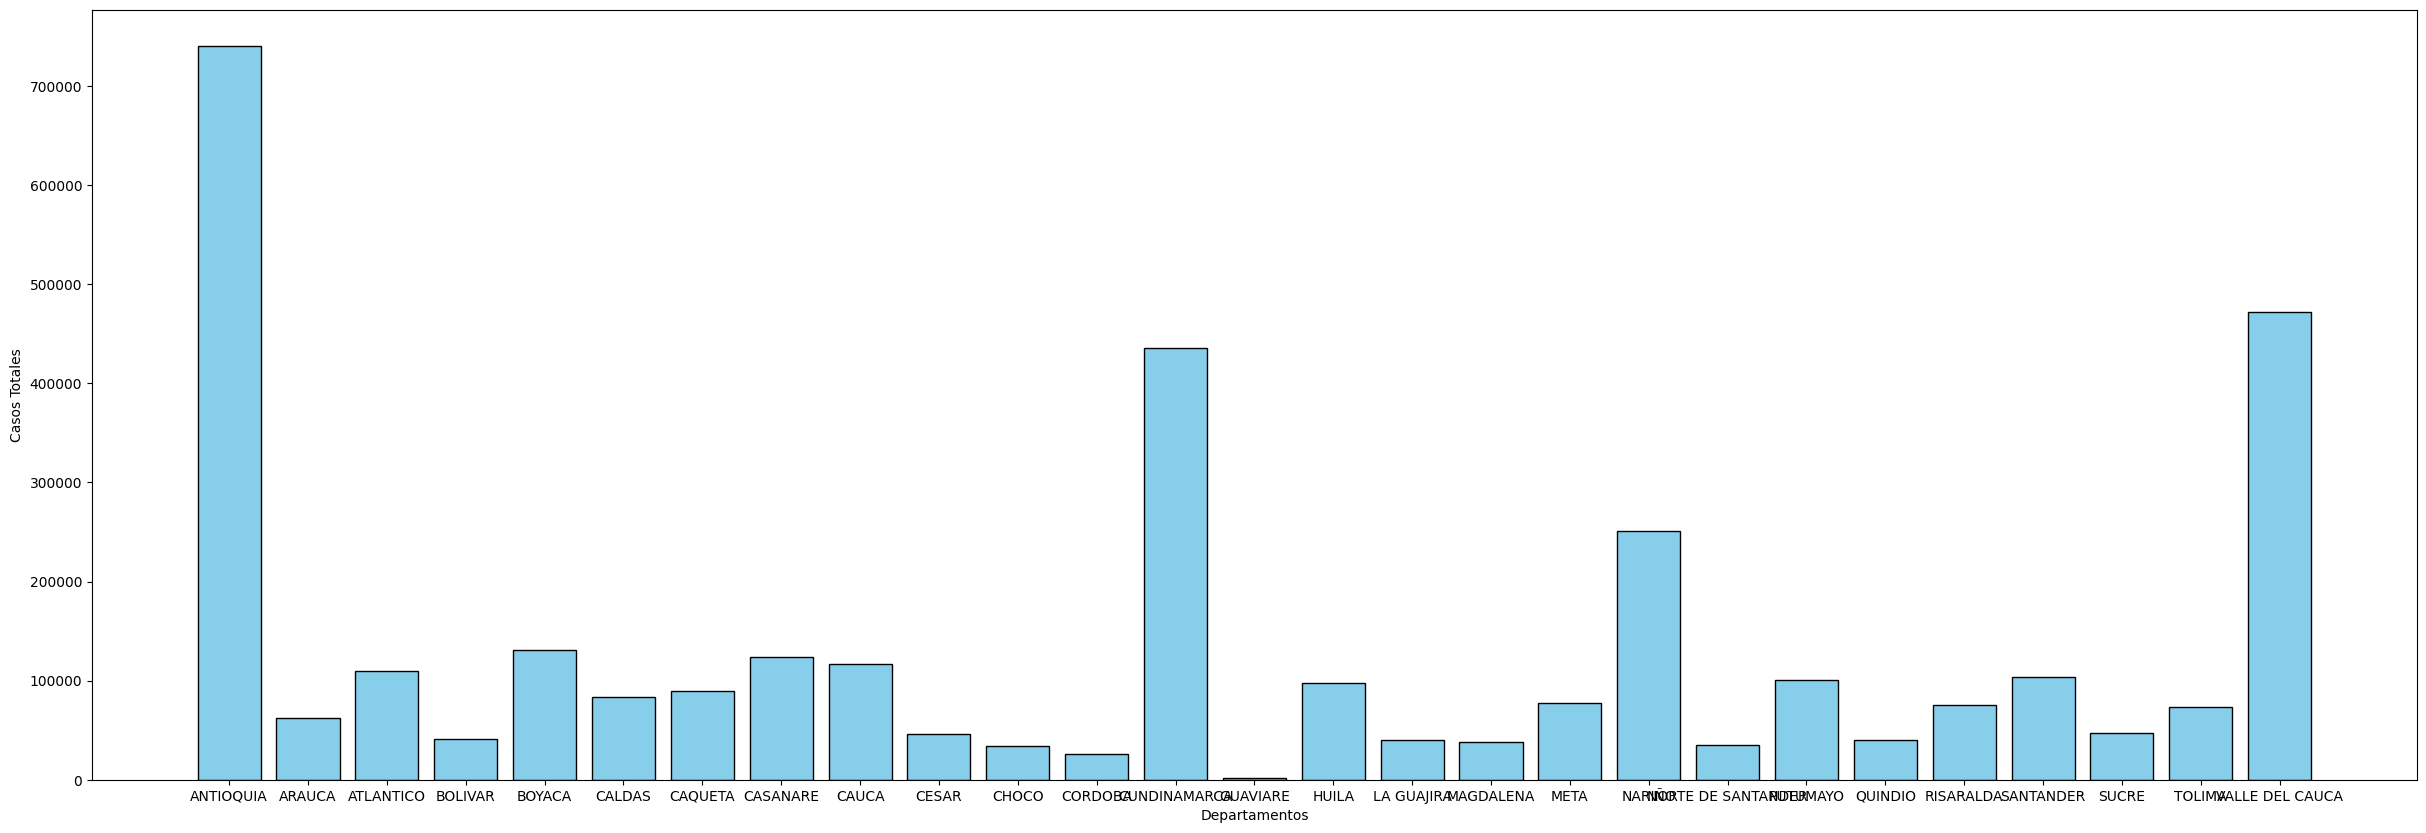

In [9]:
plt.figure(figsize=(30,10))
plt.bar(departamentos, cantidad, color = 'skyblue', edgecolor='black')
plt.xlabel('Departamentos')
plt.ylabel('Casos Totales')
plt.show()

# Creación de los modelos 
Los datos ya se han procesado, por lo que es posible iniciar con la creación de los modelos. 
Se utilizará una red neuronal LSTM para realizar las predicciones de las series de tiempo, e 
iniciaremos construyendo la arquitectura de la RN.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

## Separar los datos de entrenamiento

In [14]:
dt = dfs['ANTIOQUIA']['CantidadCasos'].values
dt

array([430, 337, 695, ..., 384, 332, 445])

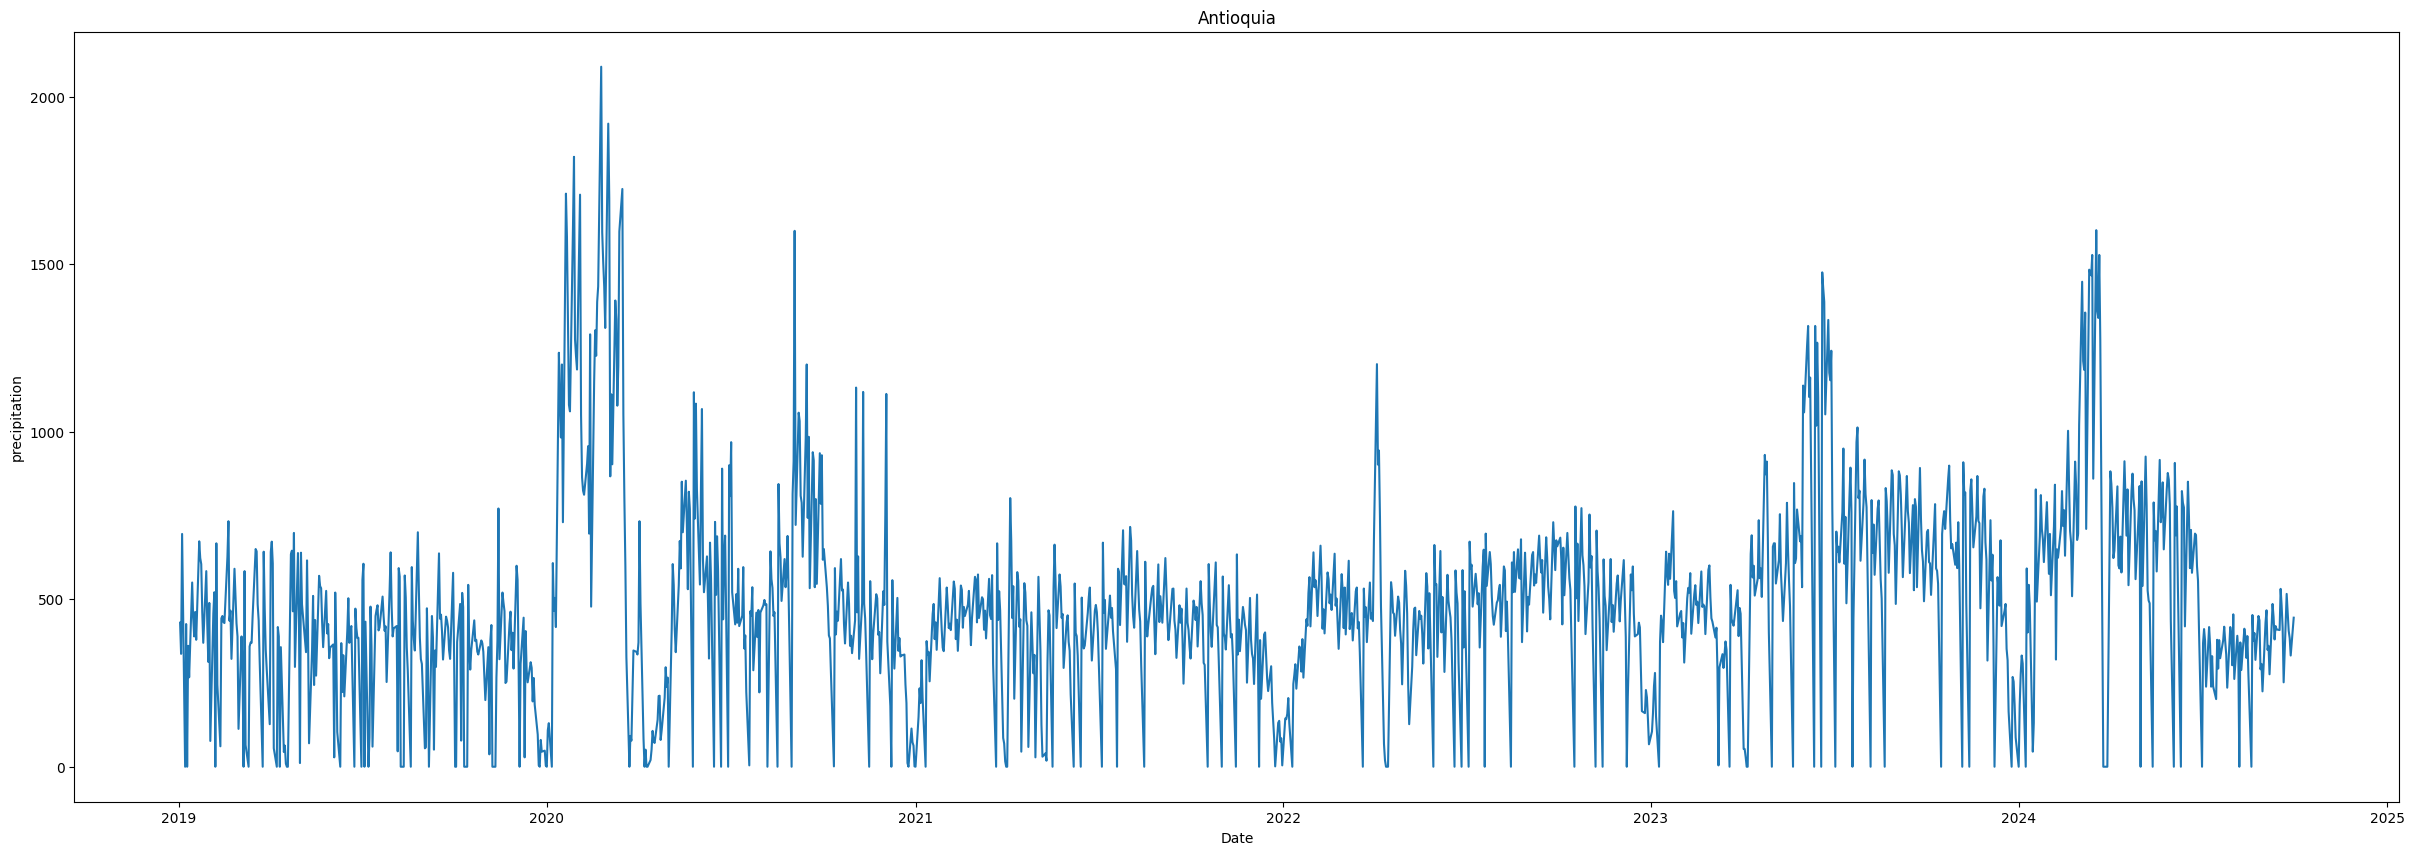

In [16]:
plt.figure(figsize = (30,10))
plt.plot(dfs['ANTIOQUIA']['FechaSolicitud'], dt)
plt.xlabel("Date")
plt.ylabel("precipitation")
plt.title('Antioquia')
plt.show()

## Normalizar datos

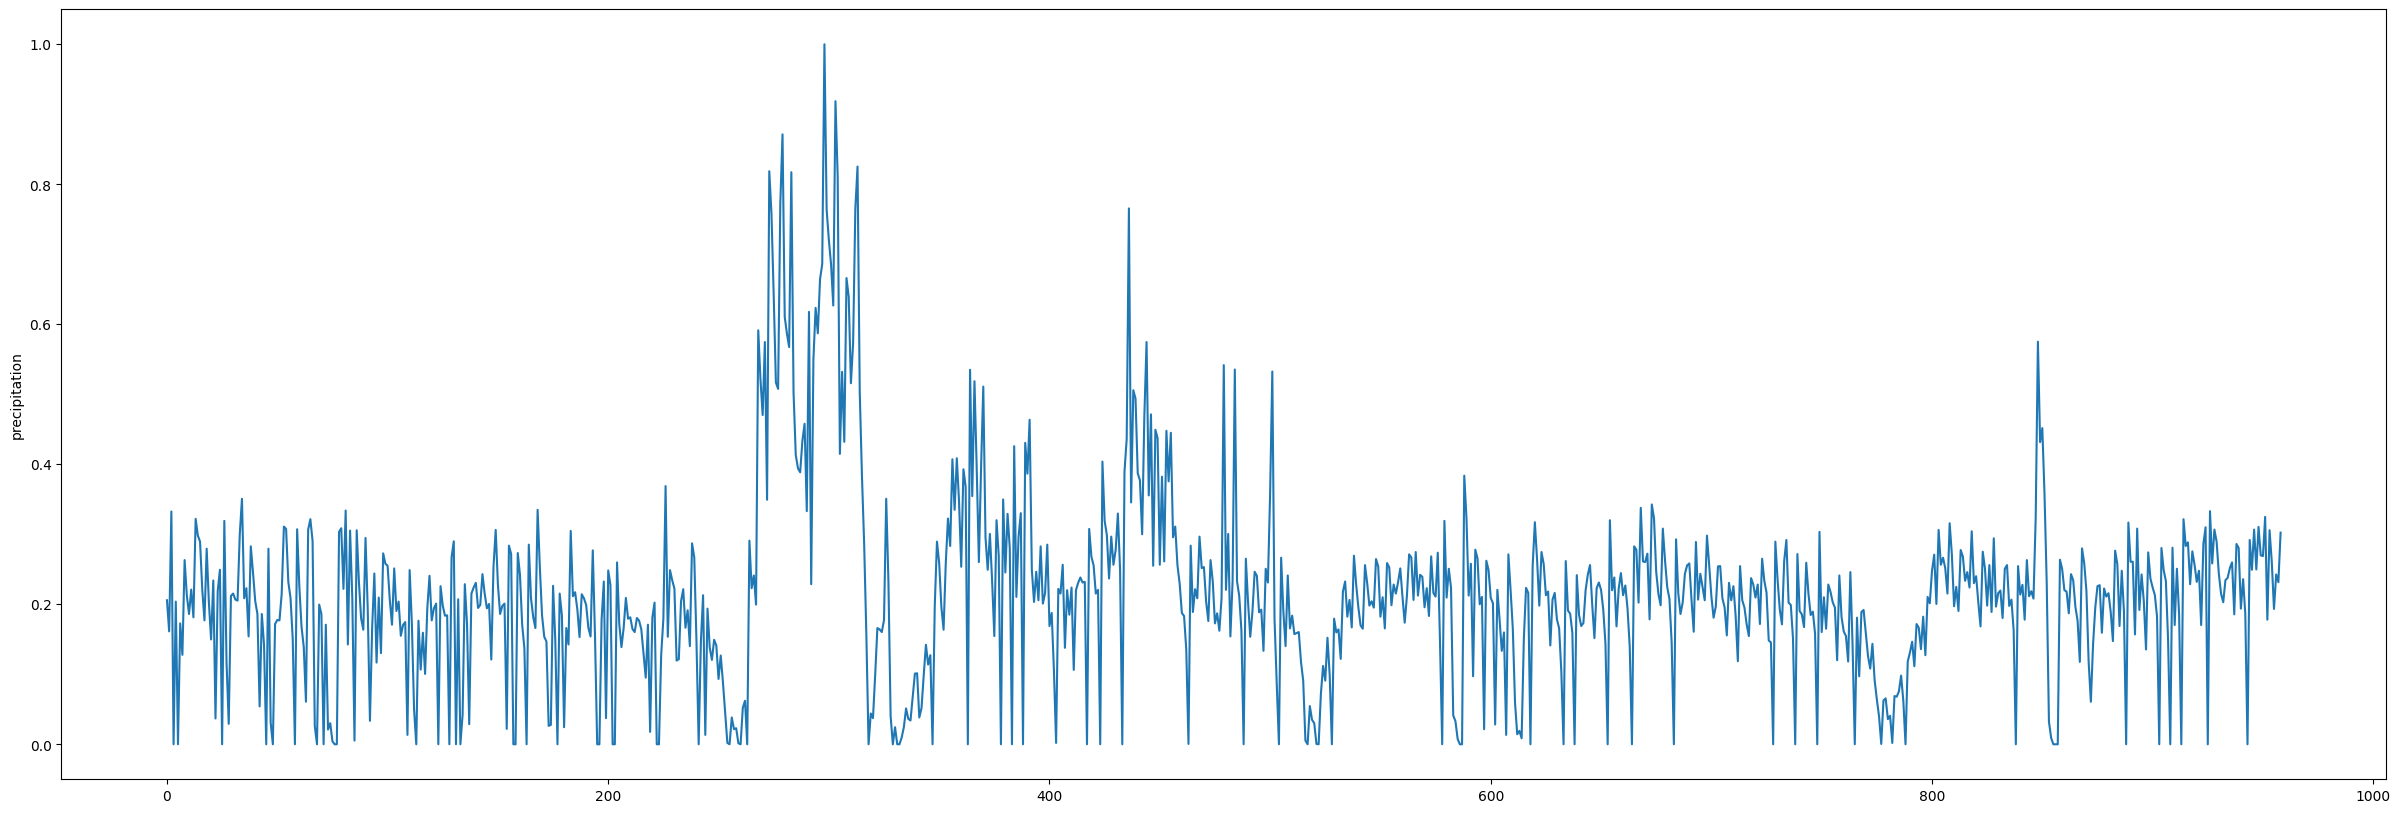

In [21]:
scaler = MinMaxScaler()
train, val, test = ft.split_data(dt)

# Reshape
train = np.array(train).reshape(-1, 1)
test = np.array(test).reshape(-1, 1)
val = np.array(val).reshape(-1, 1)

#Escalado
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)
val = scaler.fit_transform(val)

#plot
plt.figure(figsize = (30,10))
plt.plot(train)
plt.ylabel("precipitation")
plt.show()

In [22]:
# Utilizaremos dos semanas como ventana deslizante
X_train, y_train = ft.create_windows(train, 14)
X_val, y_val = ft.create_windows(val, 14)
X_test, y_test = ft.create_windows(test, 14)

## Construcción del modelo

In [26]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False,))
model.add(Dense(units=32))
model.add(Dense(units=16))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

C:\Users\PC\PycharmProjects\Datos-a-la-U\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [28]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs= 30)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 0.0229 - mean_absolute_error: 0.1134 - val_loss: 0.0306 - val_mean_absolute_error: 0.1287
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0135 - mean_absolute_error: 0.0820 - val_loss: 0.0301 - val_mean_absolute_error: 0.1282
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0118 - mean_absolute_error: 0.0774 - val_loss: 0.0284 - val_mean_absolute_error: 0.1181
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0118 - mean_absolute_error: 0.0761 - val_loss: 0.0285 - val_mean_absolute_error: 0.1204
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0107 - mean_absolute_error: 0.0754 - val_loss: 0.0289 - val_mean_absolute_error: 0.1215
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0114 - mean_absolute_error: 0.0744 - val_loss: 0.0320 - val_mean_absolute_error: 0.1193
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0118 - mean_absolute_error: 0.0816 - val_los

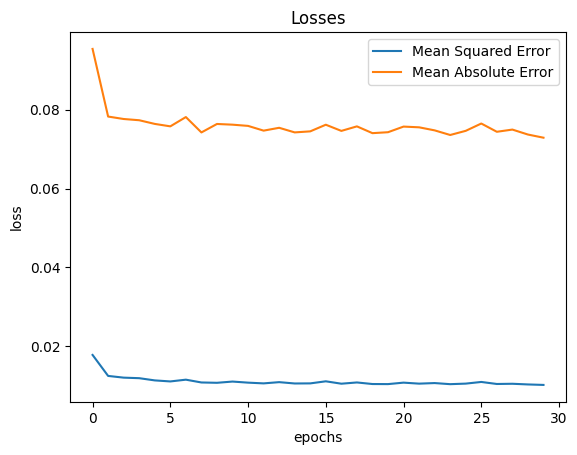

In [29]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [31]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


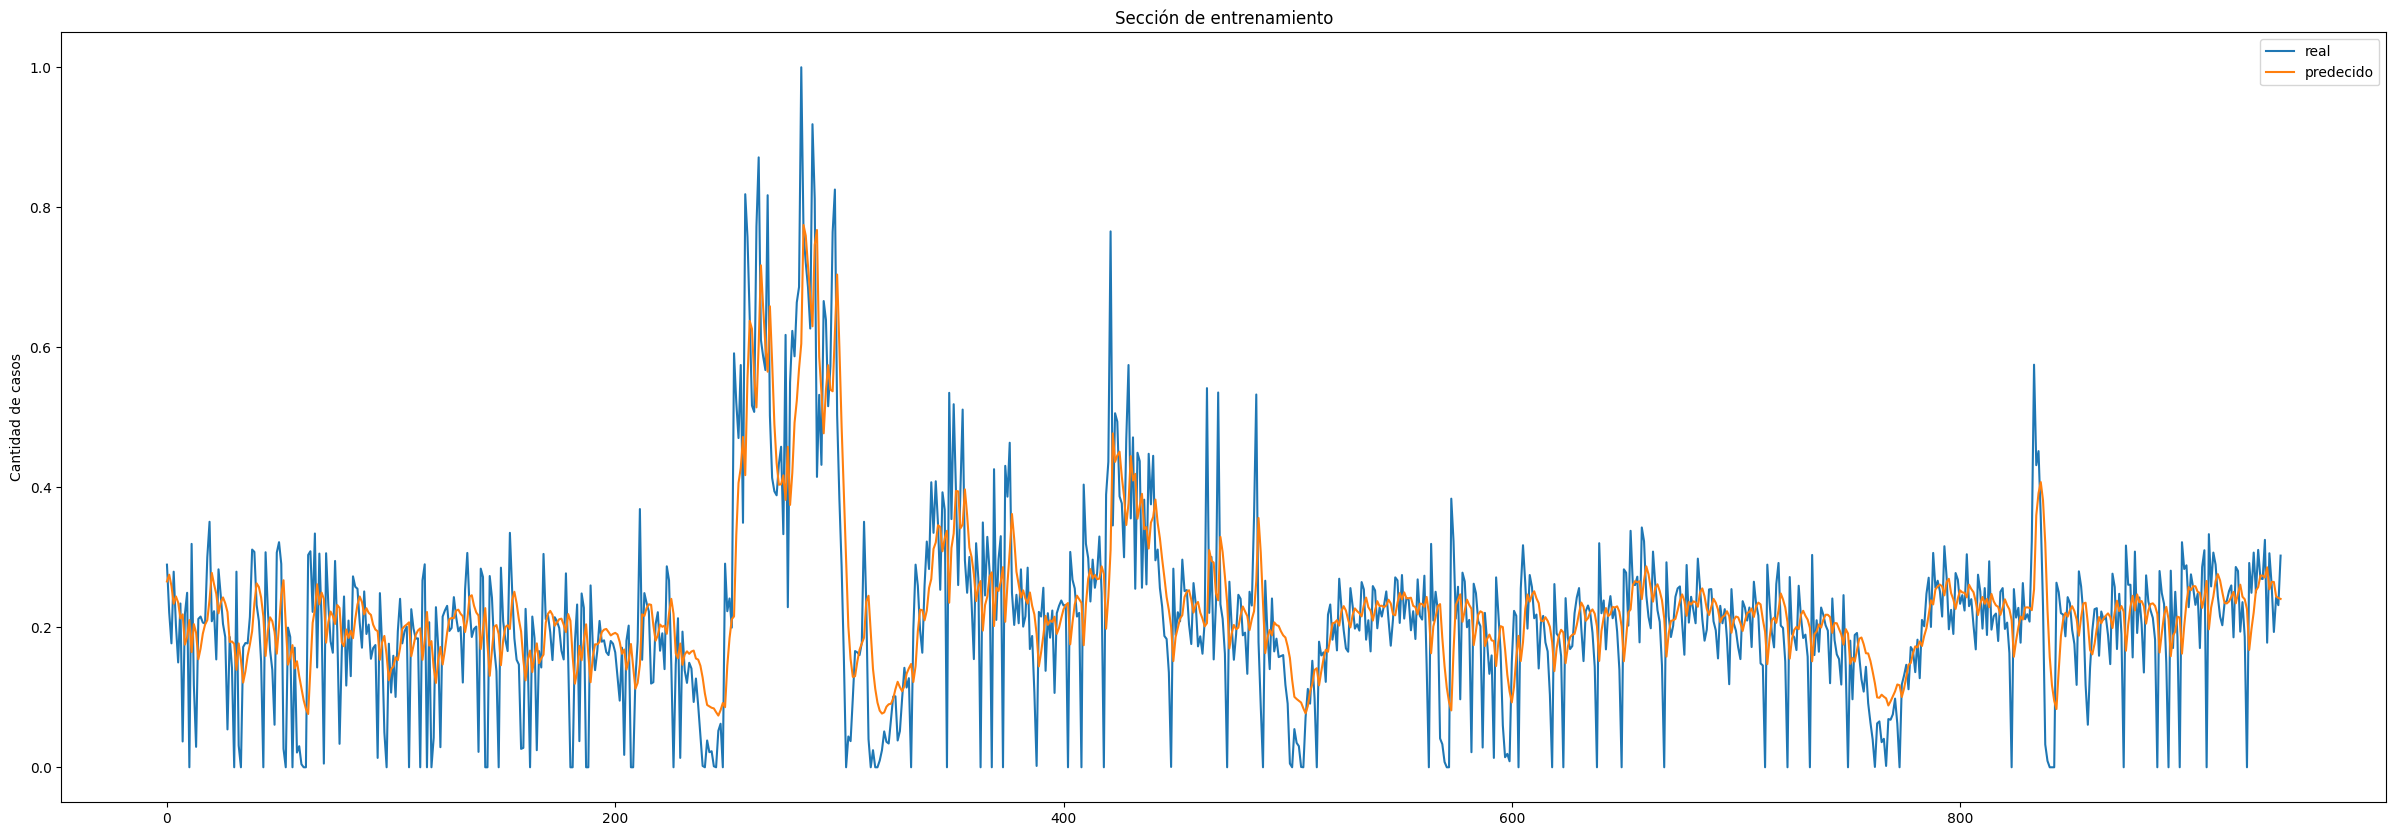

In [38]:
plt.figure(figsize = (30,10))
plt.plot(train[15:], label = "real")
plt.plot(train_pred[1:], label = "predecido")
plt.ylabel("Cantidad de casos")
plt.legend()
plt.title("Sección de entrenamiento")
plt.show()

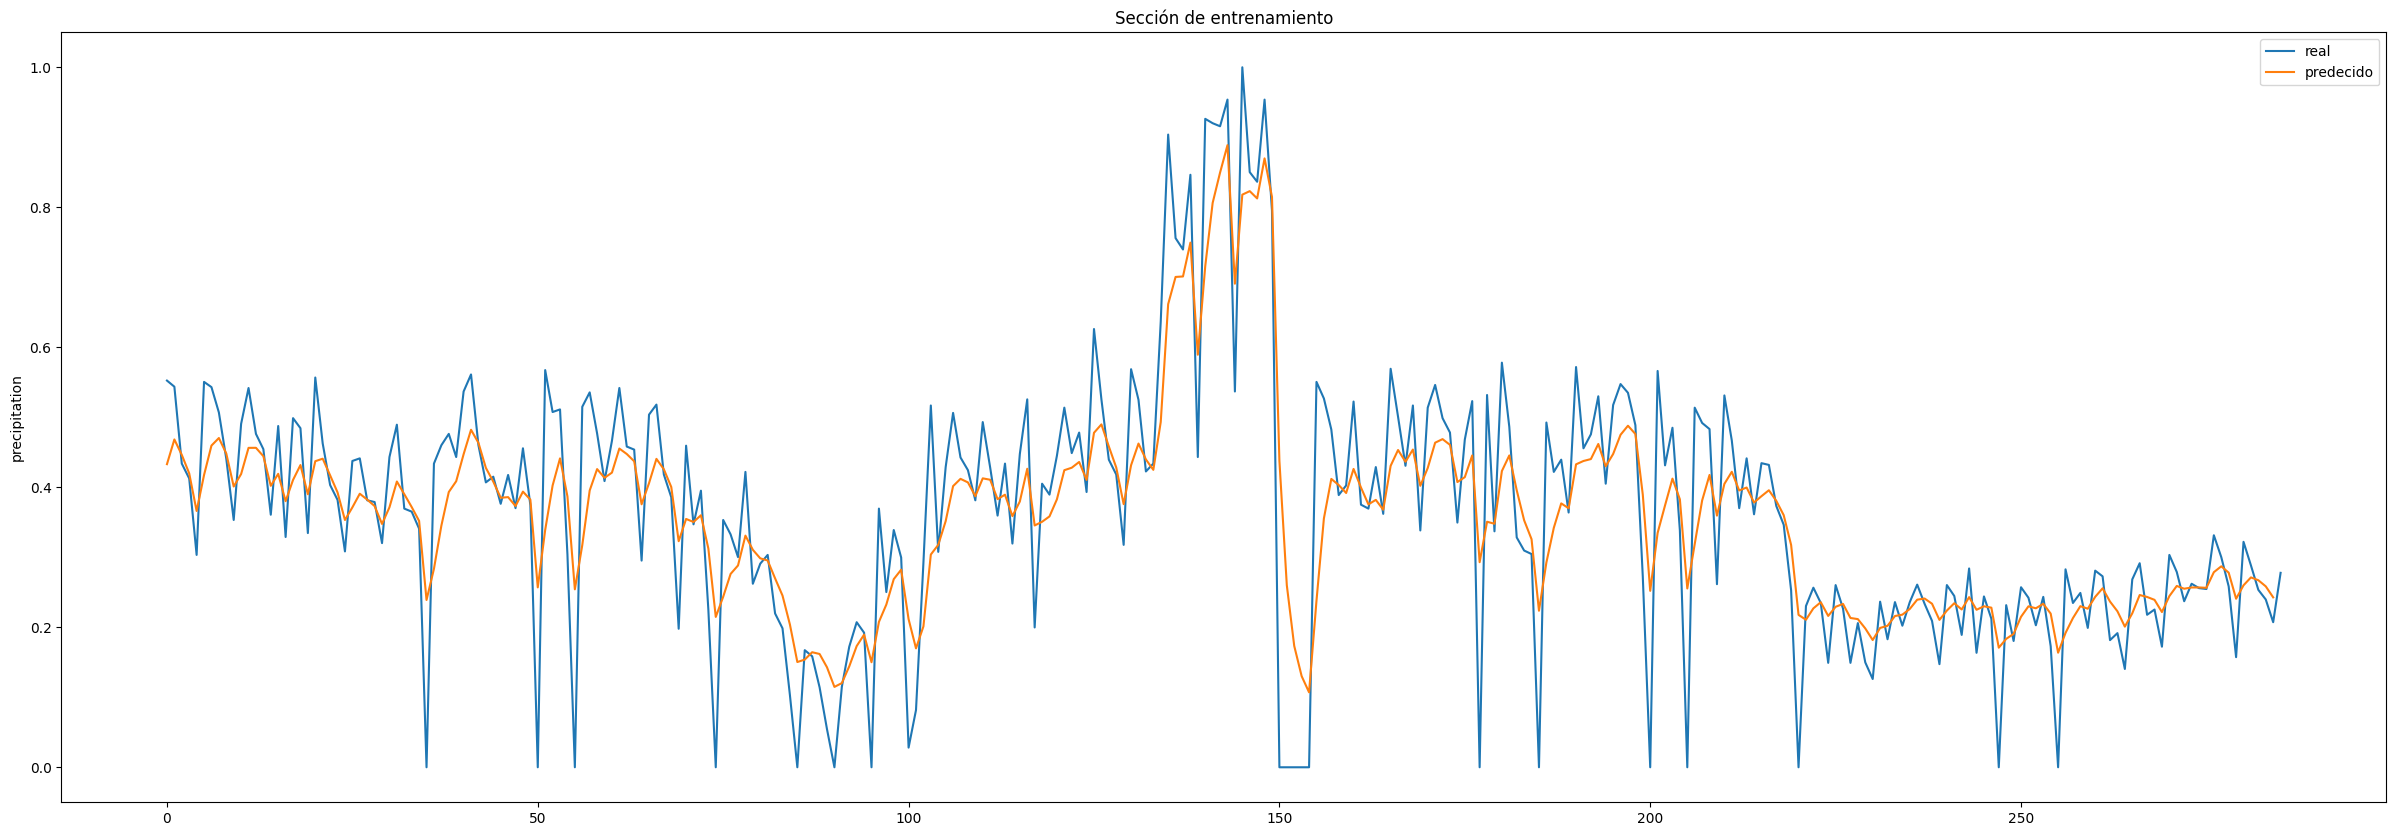

MSE: 0.0206599950353304
R2 Score: 0.4200101155578415
MAE: 0.10042396436287833
MAPE: 95971659471922.38


In [35]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
plt.figure(figsize = (30,10))
plt.plot(test[14:], label = "real")
plt.plot(test_pred[1:], label = "predecido")
plt.ylabel("precipitation")
plt.legend()
plt.title("Sección de entrenamiento")
plt.show()

# Calcular métricas
mse = mean_squared_error(test[14:], test_pred)
r2 = r2_score(test[14:], test_pred)
mae = mean_absolute_error(test[14:], test_pred)
mape = mean_absolute_percentage_error(test[14:], test_pred)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')